## Understanding Simple RNN Fundamentals

### What is a Simple RNN?

A Simple RNN (Recurrent Neural Network) is the most basic form of recurrent neural network that can process sequences of data by maintaining a "memory" of previous inputs.

Key Characteristics:

- Sequential Processing: Processes data one time step at a time

- Memory: Maintains hidden state that carries information from previous time steps

- Parameter Sharing: Uses the same weights across all time steps

- Suitable for: Short sequences (5-10 time steps) due to vanishing gradient problem



### Simple RNN Architecture


In [10]:
# Basic Simple RNN structure
# Input: [batch_size, sequence_length, features]
# Hidden State: [batch_size, hidden_units]
# Output: [batch_size, output_units]

## Code Implementation

### Change Working directory

In [11]:
import os
os.chdir('/content/drive/MyDrive/SWE/Year3Sem1/DAM_202')
os.listdir()

['text.txt',
 'my_word2vec_model.model',
 'models',
 'weather_data.csv',
 'best_simple_rnn_model.h5']

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.1 Installation and Imports

In [13]:
#Install required packages (run in terminal)
!pip install tensorflow pandas numpy matplotlib scikit-learn seaborn

In [14]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras for Simple RNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input

# Data preprocessing tools
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set random seeds for reproducible results
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("Setup completed successfully!")


TensorFlow version: 2.19.0
Setup completed successfully!


### 1.2 Data Loading and Exploration

#### 1.2.1  Load Bangladesh Weather Data

In [15]:
def load_weather_data(file_path):
    """
    Load Bangladesh weather data and create proper structure

    Expected CSV format:
    Year, Day, Wind_Speed, Specific_Humidity, Relative_Humidity, Precipitation, Temperature
    Example: 1990, 240, 3.26, 15.62, 65, 0.69, 30.65
    """

    # Load the CSV file
    df = pd.read_csv('weather_data.csv') #Same working directory

    # Define column names based on your data description
    column_names = [
        'Year', 'Day', 'Wind_Speed', 'Specific_Humidity',
        'Relative_Humidity', 'Precipitation', 'Temperature'
    ]

    # Assign column names if they're not already set
    if len(df.columns) == len(column_names):
        df.columns = column_names

    # Create proper date from Year and Day
    df['Date'] = pd.to_datetime(df['Year'] * 1000 + df['Day'], format='%Y%j')

    # Set date as index for time series analysis
    df.set_index('Date', inplace=True)

    # Remove original Year and Day columns
    df.drop(['Year', 'Day'], axis=1, inplace=True)

    print(f"Data loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"Date range: {df.index.min()} to {df.index.max()}")

    return df

# Load your data
data_file = "bangladesh_weather_data.csv"  # Replace with your file path
df = load_weather_data(data_file)


Data loaded successfully!
Shape: (12113, 5)
Date range: 1990-01-01 00:00:00 to 2023-03-01 00:00:00


In [16]:
df.head()

,Wind_Speed,Specific_Humidity,Relative_Humidity,Precipitation,Temperature
Date,,,,,
1990-01-01,1.08,5.68,53.06,0.0,16.33
1990-01-02,1.13,5.92,58.06,0.0,15.68
1990-01-03,1.33,5.68,52.69,0.0,16.56
1990-01-04,1.09,5.19,47.19,0.0,17.09
1990-01-05,0.94,4.82,42.88,0.0,17.26


In [17]:
#Compare with original dataset
main_df = pd.read_csv('weather_data.csv') #Same working directory
main_df.head()

,Year,Day,Wind Speed,Specific Humidity,Relative Humidity,Precipitation,Temperature
0,1990,1,1.08,5.68,53.06,0.0,16.33
1,1990,2,1.13,5.92,58.06,0.0,15.68
2,1990,3,1.33,5.68,52.69,0.0,16.56
3,1990,4,1.09,5.19,47.19,0.0,17.09
4,1990,5,0.94,4.82,42.88,0.0,17.26


#### 1.2.2 Data Exploration and Visualization

=== BANGLADESH WEATHER DATA EXPLORATION ===
Dataset Shape: (12113, 5)
Date Range: 1990-01-01 to 2023-03-01
Total Days: 12113 days
Years Covered: 34 years

=== BASIC STATISTICS ===
       Wind_Speed  Specific_Humidity  Relative_Humidity  Precipitation  \
count    12113.00           12113.00           12113.00       12113.00   
mean         1.31              15.21              74.64           7.18   
std          0.54               5.53              15.29          13.13   
min          0.44               2.62              15.81           0.00   
25%          0.95               9.95              65.25           0.00   
50%          1.15              16.17              79.62           1.16   
75%          1.52              20.57              86.56           9.26   
max          5.34              24.29              96.12         170.63   

       Temperature  
count     12113.00  
mean         25.04  
std           4.37  
min          11.19  
25%          21.43  
50%          26.93  
75%   

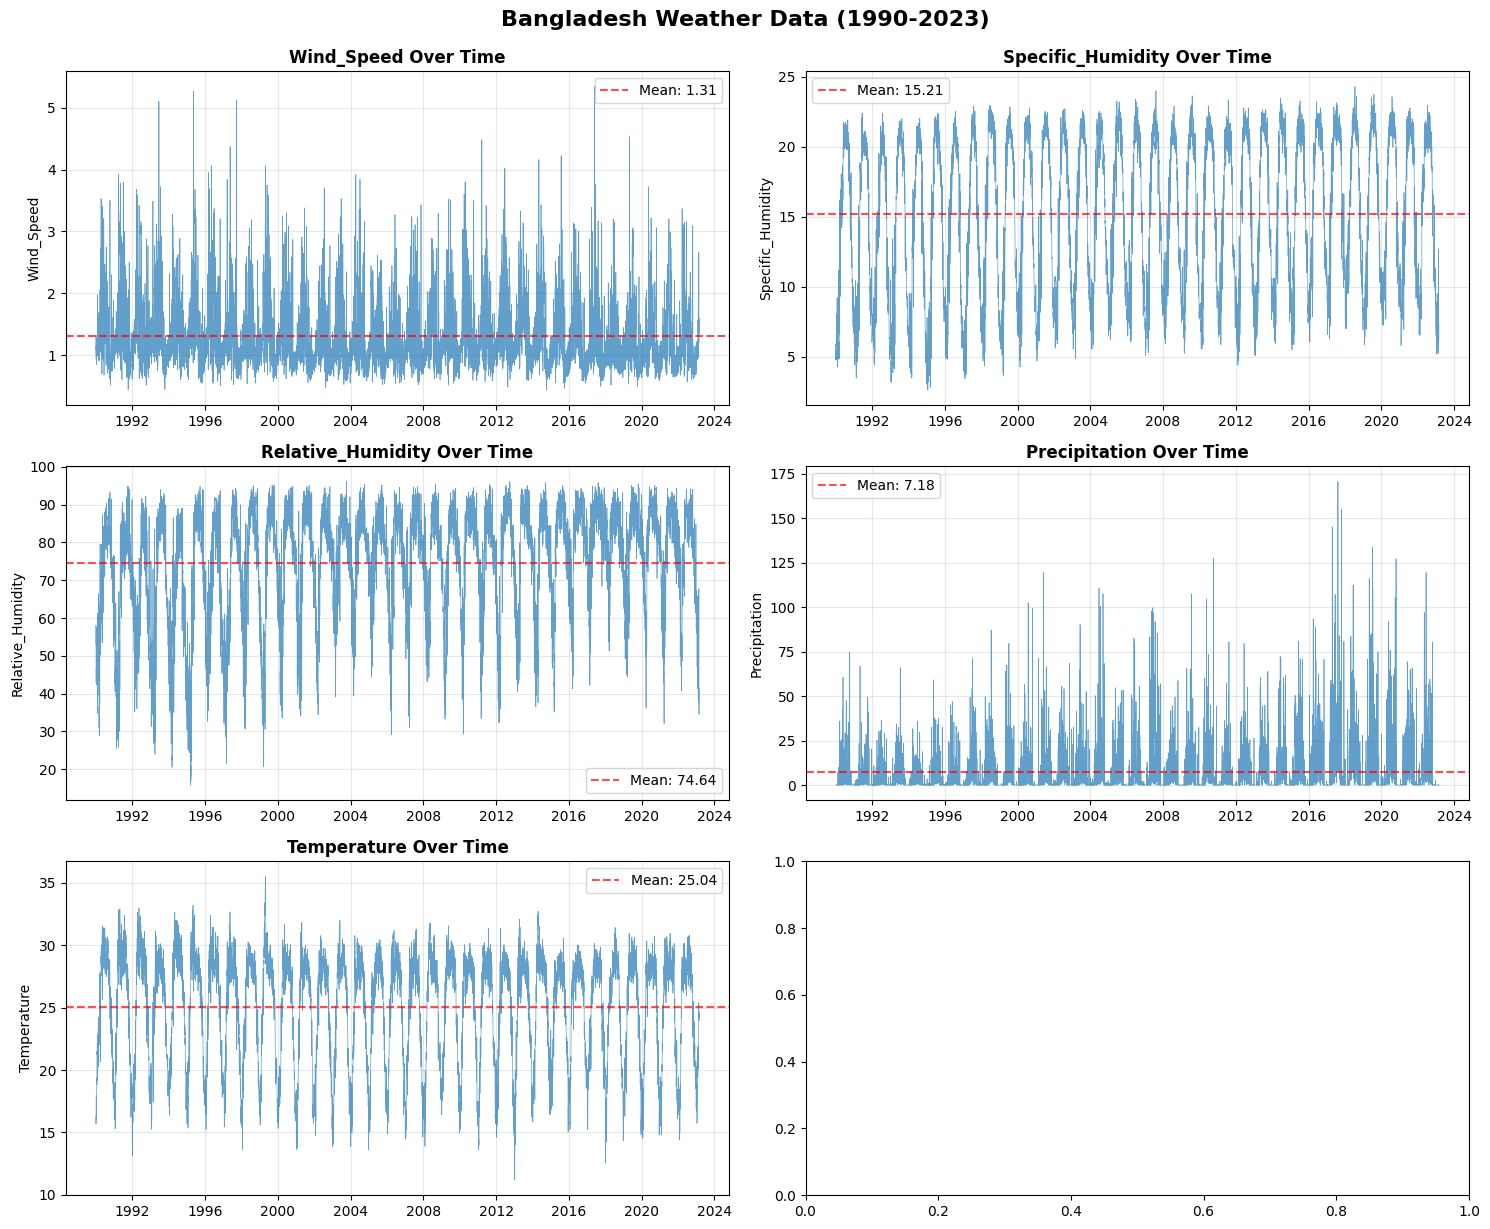

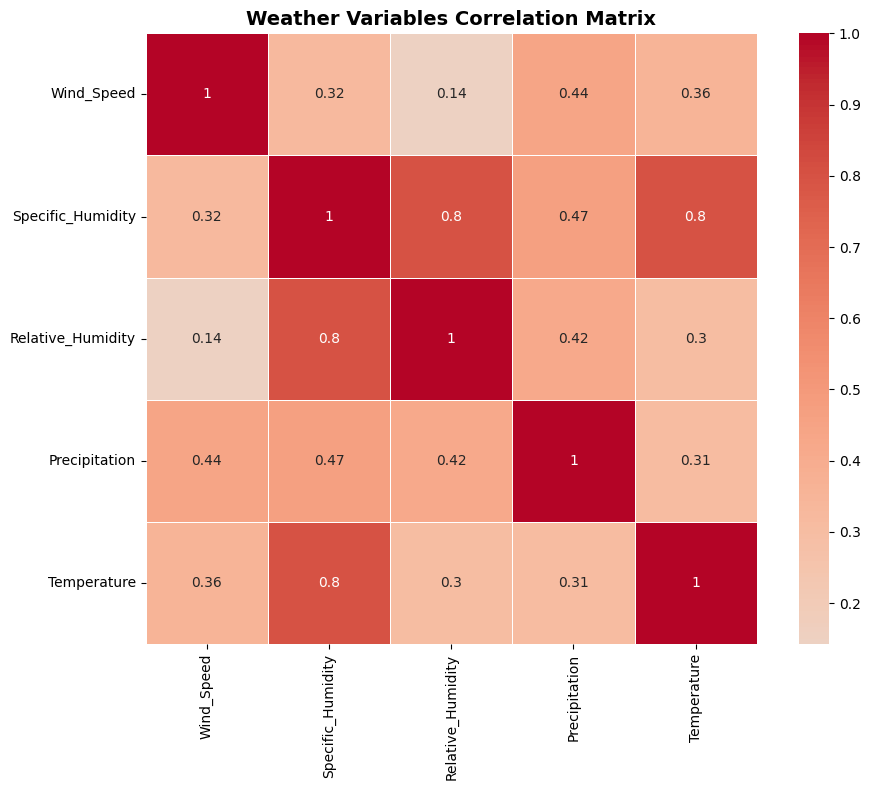

In [18]:
def explore_weather_data(df):
    """
    Comprehensive exploration of weather data
    """

    print("=== BANGLADESH WEATHER DATA EXPLORATION ===")
    print(f"Dataset Shape: {df.shape}")
    print(f"Date Range: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
    print(f"Total Days: {len(df)} days")
    print(f"Years Covered: {df.index.year.nunique()} years")

    # Basic statistics
    print("\n=== BASIC STATISTICS ===")
    print(df.describe().round(2))

    # Check for missing values
    print("\n=== MISSING VALUES ===")
    missing_values = df.isnull().sum()
    print(missing_values)

    # Data types
    print("\n=== DATA TYPES ===")
    print(df.dtypes)

    # Visualize all weather variables
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    axes = axes.flatten()

    for i, column in enumerate(df.columns):
        axes[i].plot(df.index, df[column], alpha=0.7, linewidth=0.5)
        axes[i].set_title(f'{column} Over Time', fontsize=12, fontweight='bold')
        axes[i].set_ylabel(column)
        axes[i].grid(True, alpha=0.3)

        # Add some statistics to the plot
        mean_val = df[column].mean()
        axes[i].axhline(y=mean_val, color='red', linestyle='--', alpha=0.7,
                       label=f'Mean: {mean_val:.2f}')
        axes[i].legend()

    plt.tight_layout()
    plt.suptitle('Bangladesh Weather Data (1990-2023)', fontsize=16, fontweight='bold', y=1.02)
    plt.show()

    # Correlation matrix
    plt.figure(figsize=(10, 8))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5)
    plt.title('Weather Variables Correlation Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return df

# Explore the data
df_explored = explore_weather_data(df)


### 1.3 Data Preprocessing for Simple RNN

#### 1.3.1 Data Cleaning

In [19]:
def clean_weather_data(df):
    """
    Clean the weather data for Simple RNN processing
    """

    print("=== DATA CLEANING PROCESS ===")

    # Make a copy to avoid modifying original data
    df_clean = df.copy()

    # 1. Handle missing values
    print(f"Missing values before cleaning: {df_clean.isnull().sum().sum()}")

    # Forward fill then backward fill for time series data
    df_clean = df_clean.fillna(method='ffill').fillna(method='bfill')

    print(f"Missing values after cleaning: {df_clean.isnull().sum().sum()}")

    # 2. Remove outliers using IQR method
    print("\n=== OUTLIER REMOVAL ===")

    for column in df_clean.columns:
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count outliers
        outliers_before = ((df_clean[column] < lower_bound) |
                          (df_clean[column] > upper_bound)).sum()

        # Remove outliers by clipping
        df_clean[column] = df_clean[column].clip(lower=lower_bound, upper=upper_bound)

        print(f"{column}: {outliers_before} outliers handled")

    # 3. Basic feature engineering for time series
    df_clean['Month'] = df_clean.index.month
    df_clean['Day_of_Year'] = df_clean.index.dayofyear

    # Add simple moving averages (helpful for Simple RNN)
    df_clean['Temp_MA_3'] = df_clean['Temperature'].rolling(window=3).mean()
    df_clean['Temp_MA_7'] = df_clean['Temperature'].rolling(window=7).mean()

    # Remove rows with NaN values created by moving averages
    df_clean.dropna(inplace=True)

    print(f"\nFinal dataset shape: {df_clean.shape}")

    return df_clean

# Clean the data
df_clean = clean_weather_data(df_explored)

=== DATA CLEANING PROCESS ===
Missing values before cleaning: 0
Missing values after cleaning: 0

=== OUTLIER REMOVAL ===
Wind_Speed: 661 outliers handled
Specific_Humidity: 0 outliers handled
Relative_Humidity: 152 outliers handled
Precipitation: 1089 outliers handled
Temperature: 0 outliers handled

Final dataset shape: (12107, 9)


/tmp/ipython-input-601555160.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean = df_clean.fillna(method='ffill').fillna(method='bfill')


In [20]:
df_clean.head()

,Wind_Speed,Specific_Humidity,Relative_Humidity,Precipitation,Temperature,Month,Day_of_Year,Temp_MA_3,Temp_MA_7
Date,,,,,,,,,
1990-01-07,1.04,5.49,46.81,0.0,17.98,1,7,17.510000,16.884286
1990-01-08,1.06,5.07,44.25,0.0,17.58,1,8,17.616667,17.062857
1990-01-09,0.85,4.82,42.31,0.0,17.25,1,9,17.603333,17.287143
1990-01-10,1.14,4.76,45.38,0.0,16.33,1,10,17.053333,17.254286
1990-01-11,1.07,5.07,48.44,0.0,16.15,1,11,16.576667,17.120000


#### 1.3.2 Data Normalization (Critical for Simple RNN)


In [21]:
def normalize_data_for_rnn(df, target_column='Temperature'):
    """
    Normalize data for Simple RNN training

    Important: We fit the scaler only on training data to prevent data leakage
    """

    print(f"=== DATA NORMALIZATION FOR SIMPLE RNN ===")
    print(f"Target variable: {target_column}")

    # Separate features and target
    feature_columns = [col for col in df.columns if col != target_column]

    print(f"Feature columns: {feature_columns}")
    print(f"Number of features: {len(feature_columns)}")

    # Initialize scalers
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    target_scaler = MinMaxScaler(feature_range=(0, 1))

    return df, feature_columns, feature_scaler, target_scaler

# Prepare for normalization
df_processed, feature_columns, feature_scaler, target_scaler = normalize_data_for_rnn(df_clean)

=== DATA NORMALIZATION FOR SIMPLE RNN ===
Target variable: Temperature
Feature columns: ['Wind_Speed', 'Specific_Humidity', 'Relative_Humidity', 'Precipitation', 'Month', 'Day_of_Year', 'Temp_MA_3', 'Temp_MA_7']
Number of features: 8


In [22]:
df_processed.head(2)

,Wind_Speed,Specific_Humidity,Relative_Humidity,Precipitation,Temperature,Month,Day_of_Year,Temp_MA_3,Temp_MA_7
Date,,,,,,,,,
1990-01-07,1.04,5.49,46.81,0.0,17.98,1,7,17.510000,16.884286
1990-01-08,1.06,5.07,44.25,0.0,17.58,1,8,17.616667,17.062857


These lines are for basic feature engineering in time series analysis, which helps a neural network learn patterns better by adding informative features derived from the raw data.

What are these features?
- Month: The month from each date (e.g., January, February, etc.), which helps encode potential seasonal effects (like monsoons or cold seasons).

- Day_of_Year: The position of each date in the year (e.g., 1 for January 1st, 365 for December 31st), which can capture cyclic trends and annual seasonality.

- Temp_MA_3: The average temperature over the past 3 days for each day.

- Temp_MA_7: The average temperature over the past 7 days for each day.

Why are they done?
- Month and Day_of_Year transform raw date information into numerical features so that machine learning models can learn from seasonal patterns (e.g., temperature might be higher in June than in December).

- Moving averages (Temp_MA_3 and Temp_MA_7) smooth the original temperature signal. They reduce noise and short-term fluctuations, making longer-term trends and cycles more visible for the model. These features help the neural network understand not just today's temperature but also recent context, which is important for forecasting.

Why do we do this for time series models?
- Expose Patterns: Weather data shows seasonal/cyclic behaviors; encoding month and day-of-year helps the model pick up on regular patterns.

- Reduce Noise: Moving averages help to “smooth out” outlier values, giving the model a clearer picture of underlying trends.

Learning Context: RNNs thrive when they can access recent history. Including moving averages lets the model access summarized context of the recent past, not just raw daily values

#### 1.3.3 Time Series Train-Test Split

In [23]:
def create_time_series_split(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Create time-aware train/validation/test split for time series

    Important: No shuffling to maintain temporal order!
    """

    print(f"=== TIME SERIES DATA SPLITTING ===")

    n_samples = len(df)

    # Calculate split indices
    train_end = int(n_samples * train_ratio)
    val_end = int(n_samples * (train_ratio + val_ratio))

    # Split data maintaining temporal order
    train_data = df.iloc[:train_end].copy()
    val_data = df.iloc[train_end:val_end].copy()
    test_data = df.iloc[val_end:].copy()

    print(f"Training data: {len(train_data)} samples ({train_data.index.min()} to {train_data.index.max()})")
    print(f"Validation data: {len(val_data)} samples ({val_data.index.min()} to {val_data.index.max()})")
    print(f"Test data: {len(test_data)} samples ({test_data.index.min()} to {test_data.index.max()})")

    return train_data, val_data, test_data

# Split the data
train_data, val_data, test_data = create_time_series_split(df_processed)

=== TIME SERIES DATA SPLITTING ===
Training data: 8474 samples (1990-01-07 00:00:00 to 2013-03-20 00:00:00)
Validation data: 1816 samples (2013-03-21 00:00:00 to 2018-03-10 00:00:00)
Test data: 1817 samples (2018-03-11 00:00:00 to 2023-03-01 00:00:00)


In [24]:
train_data.head(2)

,Wind_Speed,Specific_Humidity,Relative_Humidity,Precipitation,Temperature,Month,Day_of_Year,Temp_MA_3,Temp_MA_7
Date,,,,,,,,,
1990-01-07,1.04,5.49,46.81,0.0,17.98,1,7,17.510000,16.884286
1990-01-08,1.06,5.07,44.25,0.0,17.58,1,8,17.616667,17.062857


### 1.4 Creating Sequences for Simple RNN

#### Understanding Sequence Creation
Simple RNNs work best with shorter sequences (5-7 days) due to the vanishing gradient problem. Here's how we create sequences:



In [25]:
def create_sequences_for_simple_rnn(features, target, sequence_length=5):
    """
    Create sequences for Simple RNN training

    For Simple RNN, we use shorter sequences (5-7 days) for better performance

    Parameters:
    - data: scaled data array
    - target_column: index of target column
    - sequence_length: number of time steps to look back (keep it short for Simple RNN)
    """

    sequences = []
    targets = []

    # Create sequences
    for i in range(sequence_length, len(features)):
        # Get sequence of past 'sequence_length' days
        sequences.append(features[i-sequence_length:i])  # Shape: (sequence_length, features)

        # Get target (next day's temperature)
        targets.append(target[i])  # Single value

    return np.array(sequences), np.array(targets)

In [38]:
def prepare_data_for_simple_rnn(train_data, val_data, test_data,
                               feature_columns, target_column,
                               feature_scaler, target_scaler,
                               sequence_length=5):
    """
    Complete data preparation pipeline for Simple RNN
    """

    print(f"=== PREPARING DATA FOR SIMPLE RNN ===")
    print(f"Sequence length: {sequence_length} days")
    print(f"Target: {target_column}")
    print(f"Features: {feature_columns}")

    # 1. Scale the data (fit only on training data!)
    train_features_scaled = feature_scaler.fit_transform(train_data[feature_columns])
    train_target_scaled = target_scaler.fit_transform(train_data[[target_column]])
    print(f"Train Target : {train_target_scaled.flatten().shape}")

    val_features_scaled = feature_scaler.transform(val_data[feature_columns])
    val_target_scaled = target_scaler.transform(val_data[[target_column]])

    test_features_scaled = feature_scaler.transform(test_data[feature_columns])
    test_target_scaled = target_scaler.transform(test_data[[target_column]])

    # 2. Combine features and target for sequence creation
    train_combined = np.column_stack([train_features_scaled, train_target_scaled])
    val_combined = np.column_stack([val_features_scaled, val_target_scaled])
    test_combined = np.column_stack([test_features_scaled, test_target_scaled])

    # 3. Find target column index in combined array
    #target_idx = train_data.columns.get_loc('Temperature')

    # 4. Create sequences
    X_train, y_train = create_sequences_for_simple_rnn(train_features_scaled, train_target_scaled.flatten(), sequence_length)
    X_val, y_val = create_sequences_for_simple_rnn(val_features_scaled, val_target_scaled.flatten(), sequence_length)
    X_test, y_test = create_sequences_for_simple_rnn(test_features_scaled, test_target_scaled.flatten(), sequence_length)


    print(f"Training sequences: {X_train.shape}")
    print(f"Training targets: {y_train.shape}")
    print(f"Validation sequences: {X_val.shape}")
    print(f"Test sequences: {X_test.shape}")

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

# Prepare sequences (using short sequence length for Simple RNN)
SEQUENCE_LENGTH = 3  # Changed sequence length to 3 for Exercise 1

(X_train, y_train), (X_val, y_val), (X_test, y_test) = prepare_data_for_simple_rnn(
    train_data, val_data, test_data,
    feature_columns, 'Temperature',
    feature_scaler, target_scaler,
    sequence_length=SEQUENCE_LENGTH
)

print("Data preparation completed successfully!")

=== PREPARING DATA FOR SIMPLE RNN ===
Sequence length: 3 days
Target: Temperature
Features: ['Wind_Speed', 'Specific_Humidity', 'Relative_Humidity', 'Precipitation', 'Month', 'Day_of_Year', 'Temp_MA_3', 'Temp_MA_7']
Train Target : (8474,)
Training sequences: (8471, 3, 8)
Training targets: (8471,)
Validation sequences: (1813, 3, 8)
Test sequences: (1814, 3, 8)
Data preparation completed successfully!


In [27]:
X_train[100]

array([[0.53506494, 0.59709874, 0.48388637, 0.04406048, 0.27272727,
        0.29041096, 0.74475574, 0.72374025],
       [1.        , 0.60832943, 0.50473462, 0.15809935, 0.27272727,
        0.29315068, 0.74292552, 0.73180001],
       [1.        , 0.59709874, 0.49980107, 0.21900648, 0.27272727,
        0.29589041, 0.73363368, 0.7322587 ],
       [1.        , 0.68834815, 0.65401448, 0.81382289, 0.27272727,
        0.29863014, 0.71913276, 0.72564052],
       [1.        , 0.72297613, 0.73645261, 1.        , 0.27272727,
        0.30136986, 0.69815571, 0.71993972]])

### 1.5 Building Simple RNN Model

#### 1.5.1 Understanding Simple RNN Architecture

In [28]:
def create_simple_rnn_model(input_shape, hidden_units=32, dropout_rate=0.2):
    """
    Create a Simple RNN model optimized for weather prediction

    Architecture:
    1. SimpleRNN layer with specified hidden units
    2. Dropout for regularization
    3. Dense layer for final prediction

    Parameters:
    - input_shape: (sequence_length, number_of_features)
    - hidden_units: number of neurons in RNN layer
    - dropout_rate: dropout rate for regularization
    """

    print(f"=== BUILDING SIMPLE RNN MODEL ===")
    print(f"Input shape: {input_shape}")
    print(f"Hidden units: {hidden_units}")
    print(f"Dropout rate: {dropout_rate}")

    model = Sequential(name="Simple_RNN_Weather_Predictor")

    # Add Input layer to specify input shape
    model.add(Input(shape=input_shape, name='Input_Layer'))

    # Add SimpleRNN layer without input_shape argument
    model.add(SimpleRNN(
        units=hidden_units,
        activation='tanh',  # Default activation
        dropout=dropout_rate,
        recurrent_dropout=dropout_rate,
        name='SimpleRNN_Layer'
    ))


    # Add dropout for additional regularization
    model.add(Dropout(dropout_rate, name='Dropout_Layer'))

    # Add dense layer for final prediction
    model.add(Dense(
        units=1,
        activation='linear',  # Linear activation for regression
        name='Output_Layer'
    ))

    # Compile the model
    optimizer = Adam(learning_rate=0.001)

    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        metrics=['mean_absolute_error', 'mean_absolute_percentage_error']
    )

    # Display model summary
    print("\n=== MODEL ARCHITECTURE ===")
    model.summary()

    return model

# Create the Simple RNN model
input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, features)
model = create_simple_rnn_model(input_shape, hidden_units=32, dropout_rate=0.2)

=== BUILDING SIMPLE RNN MODEL ===
Input shape: (5, 8)
Hidden units: 32
Dropout rate: 0.2

=== MODEL ARCHITECTURE ===


Model: "Simple_RNN_Weather_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ SimpleRNN_Layer (SimpleRNN)     │ (None, 32)             │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,345 (5.25 KB)

 Trainable params: 1,345 (5.25 KB)

 Non-trainable params: 0 (0.00 B)

#### 1.5.2 Model Training Strategy

In [29]:
def train_simple_rnn_model(model, X_train, y_train, X_val, y_val,
                          epochs=100, batch_size=32, patience=10):
    """
    Train Simple RNN model with proper callbacks

    Simple RNN training considerations:
    - Lower epochs (50) due to faster convergence
    - Early stopping to prevent overfitting
    - Learning rate reduction for better convergence
    """

    print(f"=== TRAINING SIMPLE RNN MODEL ===")
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Epochs: {epochs}")
    print(f"Batch size: {batch_size}")

    # Define callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True,
            verbose=1,
            min_delta=0.001
        ),
        ModelCheckpoint(
            'best_simple_rnn_model.h5',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]

    # Train the model
    print("\nStarting training...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1,
        shuffle=False  # Important: Don't shuffle time series data
    )

    print("Training completed!")
    return history

# Train the model
training_history = train_simple_rnn_model(
    model, X_train, y_train, X_val, y_val,
    epochs=100, batch_size=32, patience=10
)


=== TRAINING SIMPLE RNN MODEL ===
Training samples: 8469
Validation samples: 1811
Epochs: 100
Batch size: 32

Starting training...
Epoch 1/100
261/265 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1791 - mean_absolute_error: 0.3270 - mean_absolute_percentage_error: 63.0494
Epoch 1: val_loss improved from inf to 0.00538, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.1780 - mean_absolute_error: 0.3258 - mean_absolute_percentage_error: 687.0649 - val_loss: 0.0054 - val_mean_absolute_error: 0.0566 - val_mean_absolute_percentage_error: 12.3752
Epoch 2/100
261/265 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0497 - mean_absolute_error: 0.1750 - mean_absolute_percentage_error: 34.2549
Epoch 2: val_loss improved from 0.00538 to 0.00513, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0496 - mean_absolute_error: 0.1748 - mean_absolute_percentage_error: 267.0908 - val_loss: 0.0051 - val_mean_absolute_error: 0.0554 - val_mean_absolute_percentage_error: 13.0342
Epoch 3/100
262/265 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0308 - mean_absolute_error: 0.1394 - mean_absolute_percentage_error: 27.7284
Epoch 3: val_loss did not improve from 0.00513
265/265 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0308 - mean_absolute_error: 0.1393 - mean_absolute_percentage_error: 326.1198 - val_loss: 0.0059 - val_mean_absolute_error: 0.0596 - val_mean_absolute_percentage_error: 13.9532
Epoch 4/100
255/265 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0254 - mean_absolute_error: 0.1266 - mean_absolute_percentage_error: 25.4216
Epoch 4: val_loss did not improve from 0.00513
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0254 - mean_absolute_error: 0.1265 - mean_absolute_percentage_error: 469.8759 - val_loss: 0.0057 - val_mean_absolute_

### 1.6 Model Evaluation and Visualization

#### 1.6.1 Training History Visualization

=== TRAINING HISTORY VISUALIZATION ===


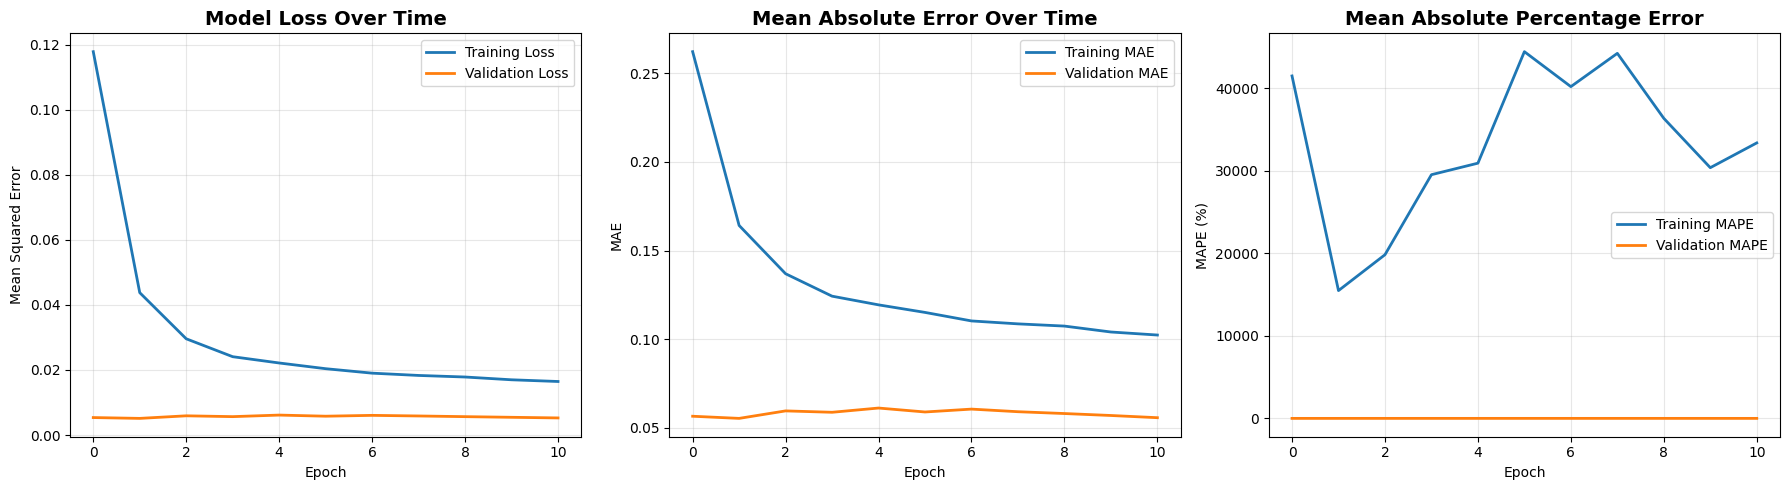

In [30]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Visualize training history for Simple RNN
    """

    print("=== TRAINING HISTORY VISUALIZATION ===")

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Loss plot
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Mean Squared Error')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # MAE plot
    axes[1].plot(history.history['mean_absolute_error'], label='Training MAE', linewidth=2)
    axes[1].plot(history.history['val_mean_absolute_error'], label='Validation MAE', linewidth=2)
    axes[1].set_title('Mean Absolute Error Over Time', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # MAPE plot
    axes[2].plot(history.history['mean_absolute_percentage_error'],
                label='Training MAPE', linewidth=2)
    axes[2].plot(history.history['val_mean_absolute_percentage_error'],
                label='Validation MAPE', linewidth=2)
    axes[2].set_title('Mean Absolute Percentage Error', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('MAPE (%)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(training_history)

#### 1.6.2 Model Performance Evaluation

In [31]:
def evaluate_simple_rnn_performance(model, X_test, y_test, target_scaler):
    """
    Comprehensive evaluation of Simple RNN performance
    """

    print("=== SIMPLE RNN MODEL EVALUATION ===")

    # Make predictions
    y_pred_scaled = model.predict(X_test, verbose=0)

    # Inverse transform to original scale
    y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_original = target_scaler.inverse_transform(y_pred_scaled).flatten()

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_original, y_pred_original)
    r2 = r2_score(y_test_original, y_pred_original)

    # Calculate MAPE manually
    mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100

    # Temperature-specific accuracy (within certain degrees)
    accuracy_1deg = np.mean(np.abs(y_test_original - y_pred_original) <= 1.0) * 100
    accuracy_2deg = np.mean(np.abs(y_test_original - y_pred_original) <= 2.0) * 100
    accuracy_3deg = np.mean(np.abs(y_test_original - y_pred_original) <= 3.0) * 100

    # Print results
    print("\n🌤️  SIMPLE RNN WEATHER PREDICTION RESULTS 🌤️")
    print("=" * 55)
    print(f"📊 Mean Squared Error (MSE):      {mse:.4f}")
    print(f"📊 Root Mean Squared Error (RMSE): {rmse:.4f}°C")
    print(f"📊 Mean Absolute Error (MAE):     {mae:.4f}°C")
    print(f"📊 R-squared Score (R²):          {r2:.4f}")
    print(f"📊 Mean Absolute Percentage Error: {mape:.2f}%")
    print("=" * 55)
    print("🎯 TEMPERATURE PREDICTION ACCURACY:")
    print(f"   Within ±1°C: {accuracy_1deg:.1f}% of predictions")
    print(f"   Within ±2°C: {accuracy_2deg:.1f}% of predictions")
    print(f"   Within ±3°C: {accuracy_3deg:.1f}% of predictions")
    print("=" * 55)

    return {
        'y_true': y_test_original,
        'y_pred': y_pred_original,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape,
        'accuracy_1deg': accuracy_1deg,
        'accuracy_2deg': accuracy_2deg,
        'accuracy_3deg': accuracy_3deg
    }

# Evaluate the model
evaluation_results = evaluate_simple_rnn_performance(model, X_test, y_test, target_scaler)

=== SIMPLE RNN MODEL EVALUATION ===

🌤️  SIMPLE RNN WEATHER PREDICTION RESULTS 🌤️
📊 Mean Squared Error (MSE):      3.2431
📊 Root Mean Squared Error (RMSE): 1.8009°C
📊 Mean Absolute Error (MAE):     1.4100°C
📊 R-squared Score (R²):          0.8264
📊 Mean Absolute Percentage Error: 6.15%
🎯 TEMPERATURE PREDICTION ACCURACY:
   Within ±1°C: 44.6% of predictions
   Within ±2°C: 74.9% of predictions
   Within ±3°C: 89.6% of predictions


#### 1.6.3 Prediction Visualization

=== PREDICTION VISUALIZATION ===


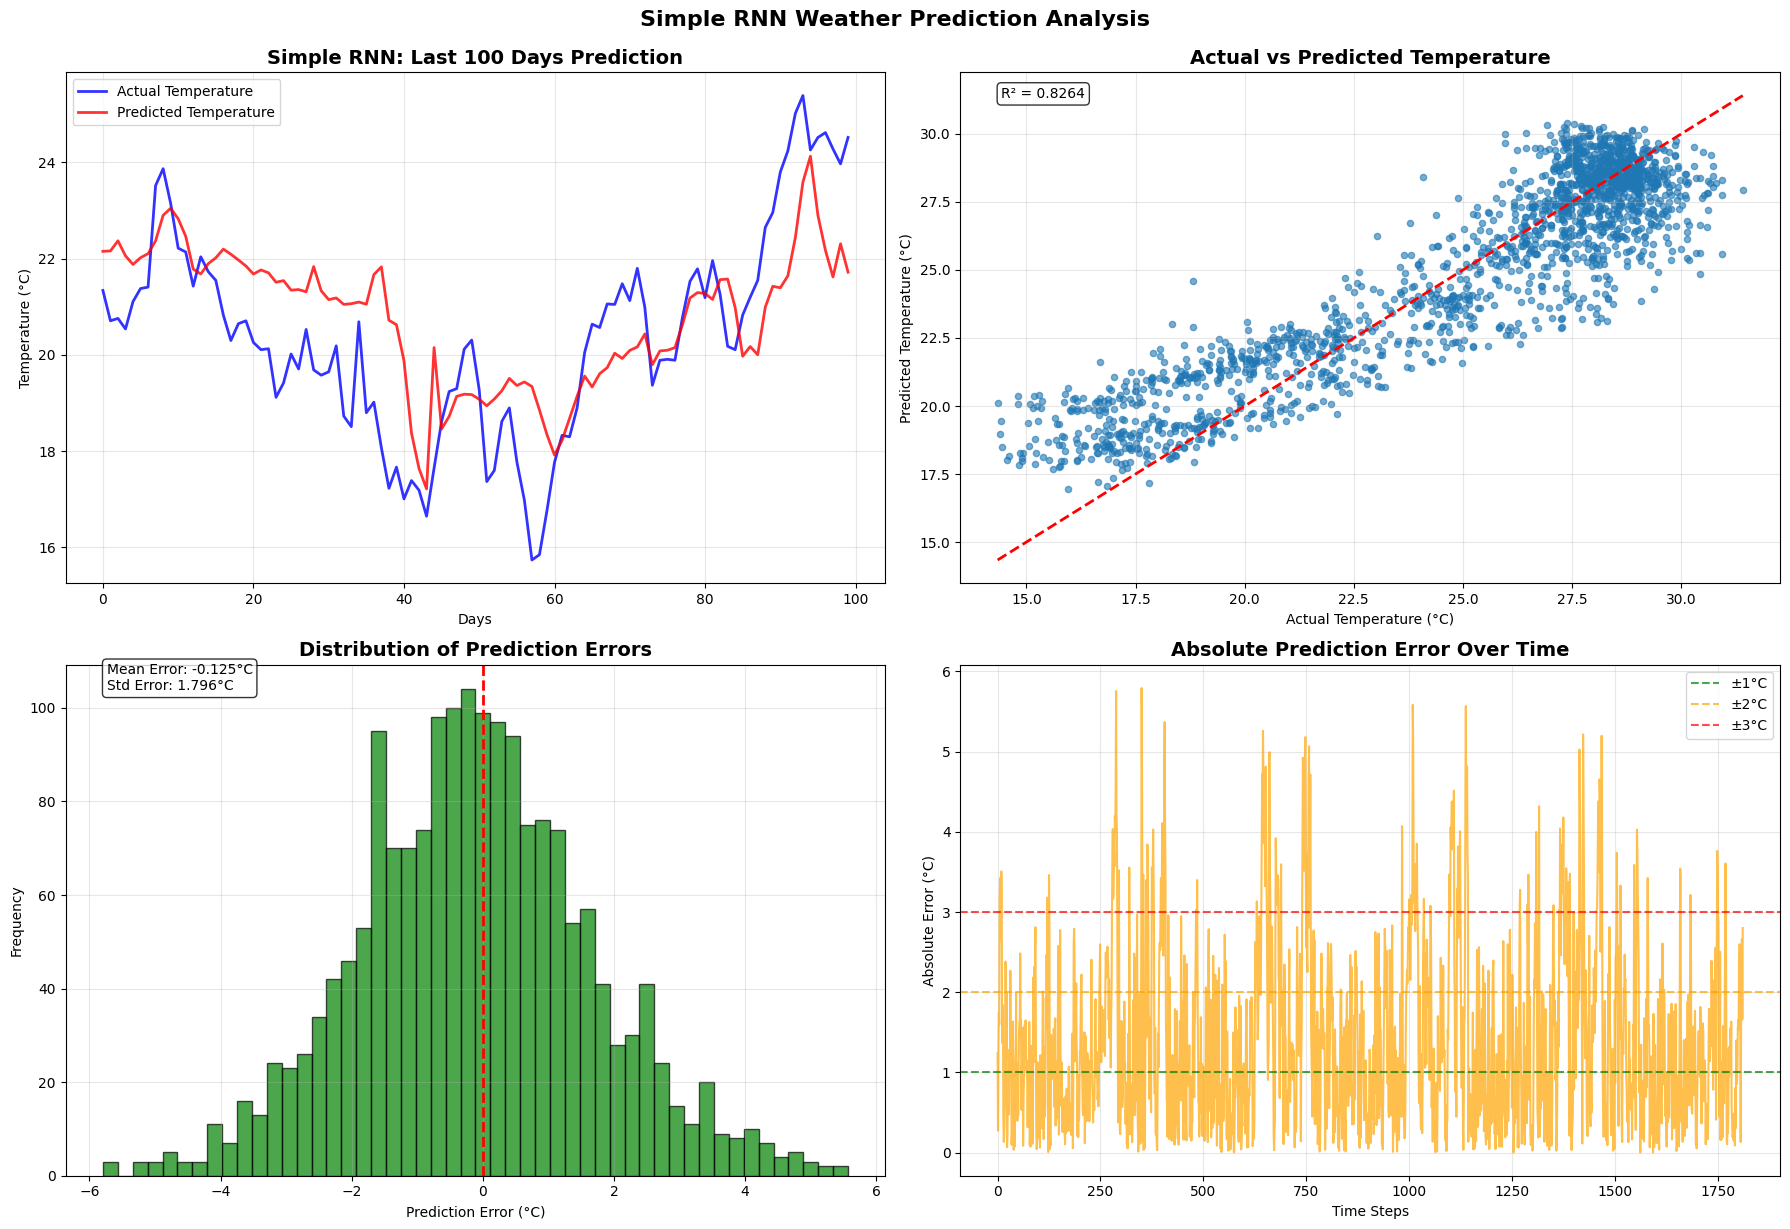

In [32]:
def visualize_predictions(results, days_to_show=100):
    """
    Create comprehensive visualizations of Simple RNN predictions
    """

    print(f"=== PREDICTION VISUALIZATION ===")

    y_true = results['y_true']
    y_pred = results['y_pred']

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    # 1. Time series plot (last N days)
    axes[0, 0].plot(y_true[-days_to_show:], label='Actual Temperature',
                   linewidth=2, alpha=0.8, color='blue')
    axes[0, 0].plot(y_pred[-days_to_show:], label='Predicted Temperature',
                   linewidth=2, alpha=0.8, color='red')
    axes[0, 0].set_title(f'Simple RNN: Last {days_to_show} Days Prediction',
                        fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Days')
    axes[0, 0].set_ylabel('Temperature (°C)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Scatter plot: Actual vs Predicted
    axes[0, 1].scatter(y_true, y_pred, alpha=0.6, s=20)
    min_temp, max_temp = y_true.min(), y_true.max()
    axes[0, 1].plot([min_temp, max_temp], [min_temp, max_temp], 'r--', lw=2)
    axes[0, 1].set_xlabel('Actual Temperature (°C)')
    axes[0, 1].set_ylabel('Predicted Temperature (°C)')
    axes[0, 1].set_title('Actual vs Predicted Temperature', fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)

    # Add R² to scatter plot
    r2 = results['r2']
    axes[0, 1].text(0.05, 0.95, f'R² = {r2:.4f}', transform=axes[0, 1].transAxes,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # 3. Error distribution
    errors = y_true - y_pred
    axes[1, 0].hist(errors, bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[1, 0].set_xlabel('Prediction Error (°C)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Prediction Errors', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)

    # Add error statistics
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    axes[1, 0].text(0.05, 0.95, f'Mean Error: {mean_error:.3f}°C\nStd Error: {std_error:.3f}°C',
                   transform=axes[1, 0].transAxes,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # 4. Error over time
    axes[1, 1].plot(np.abs(errors), alpha=0.7, color='orange')
    axes[1, 1].set_xlabel('Time Steps')
    axes[1, 1].set_ylabel('Absolute Error (°C)')
    axes[1, 1].set_title('Absolute Prediction Error Over Time', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

    # Add horizontal lines for accuracy thresholds
    axes[1, 1].axhline(1, color='green', linestyle='--', alpha=0.7, label='±1°C')
    axes[1, 1].axhline(2, color='orange', linestyle='--', alpha=0.7, label='±2°C')
    axes[1, 1].axhline(3, color='red', linestyle='--', alpha=0.7, label='±3°C')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.suptitle('Simple RNN Weather Prediction Analysis', fontsize=16, fontweight='bold', y=1.02)
    plt.show()

# Visualize predictions
visualize_predictions(evaluation_results, days_to_show=100)


#### 1.6.4 Real-time Prediction Function

In [33]:
def make_weather_prediction(model, recent_data, feature_scaler, target_scaler,
                           feature_columns, sequence_length=5):
    """
    Make a weather prediction using the trained Simple RNN model

    Parameters:
    - model: trained Simple RNN model
    - recent_data: pandas DataFrame with recent weather data (last 'sequence_length' days)
    - feature_scaler: fitted feature scaler
    - target_scaler: fitted target scaler
    - feature_columns: list of feature column names
    - sequence_length: number of days to use for prediction
    """

    print(f"=== MAKING NEW WEATHER PREDICTION ===")

    if len(recent_data) < sequence_length:
        raise ValueError(f"Need at least {sequence_length} days of recent data")

    # Get the last sequence_length days
    recent_sequence = recent_data[feature_columns].iloc[-sequence_length-1:-1].values

    # Scale the data
    #recent_sequence_scaled = feature_scaler.transform(recent_sequence)

    #Convert recent_sequence (numpy array) back to DataFrame with columns for scaler
    recent_sequence_df = pd.DataFrame(recent_sequence, columns=feature_columns)
    print(recent_sequence_df)


    # Now transform with feature scaler (which expects column names)
    recent_sequence_scaled = feature_scaler.transform(recent_sequence_df)

    # Reshape for model input: (1, sequence_length, features)
    input_sequence = recent_sequence_scaled.reshape(1, sequence_length, -1)

    # Make prediction (scaled)
    prediction_scaled = model.predict(input_sequence, verbose=0)

    # Inverse transform to get actual temperature
    predicted_temp = target_scaler.inverse_transform(prediction_scaled)[0, 0]

    print(f"🌡️  Predicted temperature for tomorrow: {predicted_temp:.2f}°C")

    return predicted_temp

# Example: Make prediction using last 5 days of test data
sample_recent_data = test_data.iloc[-10:]  # Last 10 days as example
prediction = make_weather_prediction(
    model, sample_recent_data, feature_scaler, target_scaler,
    feature_columns, sequence_length=SEQUENCE_LENGTH
)


=== MAKING NEW WEATHER PREDICTION ===
   Wind_Speed  Specific_Humidity  Relative_Humidity  Precipitation  Month  \
0        1.20              12.15              67.75           0.37    2.0   
1        1.28               8.85              50.44           0.00    2.0   
2        1.41               6.59              38.06           0.00    2.0   
3        1.60               6.04              34.56           0.00    2.0   
4        1.49               6.65              38.94           0.00    2.0   

   Day_of_Year  Temp_MA_3  Temp_MA_7  
0         55.0  24.890000  24.045714  
1         56.0  24.723333  24.312857  
2         57.0  24.466667  24.550000  
3         58.0  24.473333  24.618571  
4         59.0  24.290000  24.580000  
🌡️  Predicted temperature for tomorrow: 21.72°C


In [34]:
df_clean.tail(5)

,Wind_Speed,Specific_Humidity,Relative_Humidity,Precipitation,Temperature,Month,Day_of_Year,Temp_MA_3,Temp_MA_7
Date,,,,,,,,,
2023-02-25,1.28,8.85,50.44,0.0,24.52,2,56,24.723333,24.312857
2023-02-26,1.41,6.59,38.06,0.0,24.62,2,57,24.466667,24.550000
2023-02-27,1.60,6.04,34.56,0.0,24.28,2,58,24.473333,24.618571
2023-02-28,1.49,6.65,38.94,0.0,23.97,2,59,24.290000,24.580000
2023-03-01,1.36,7.39,41.38,0.0,24.52,3,60,24.256667,24.508571


In [35]:
print(f"Actual Temperture value of last data: {df_clean.tail(5)['Temperature'].values[-1]}")

Actual Temperture value of last data: 24.52


### Understanding Simple RNN Limitations

In [36]:
def analyze_simple_rnn_limitations():
    """
    Educational analysis of Simple RNN limitations for students
    """

    print("=== UNDERSTANDING SIMPLE RNN LIMITATIONS ===")
    print("\n🧠 WHY SIMPLE RNN HAS LIMITATIONS:")
    print("=" * 50)

    print("1. 📉 VANISHING GRADIENT PROBLEM:")
    print("   - Gradients become very small as they propagate back through time")
    print("   - Model struggles to learn from events more than 5-10 time steps ago")
    print("   - Weather patterns often require longer memory (weeks/months)")

    print("\n2. 🔄 SHORT-TERM MEMORY:")
    print("   - Simple RNN forgets information from distant past quickly")
    print("   - Weather has seasonal patterns that need long-term memory")
    print("   - Best performance with 3-7 day sequences")

    print("\n3. 🎯 PERFORMANCE COMPARISON:")
    print("   - Simple RNN: Good for short-term patterns")
    print("   - LSTM/GRU: Better for long-term dependencies")
    print("   - Complex weather patterns need advanced models")

    print("\n💡 WHEN TO USE SIMPLE RNN:")
    print("   ✅ Learning RNN fundamentals")
    print("   ✅ Short-term predictions (1-3 days)")
    print("   ✅ Simple patterns and trends")
    print("   ✅ Computational resource constraints")
    print("   ✅ Proof of concept projects")

    print("\n🚀 NEXT STEPS FOR STUDENTS:")
    print("   1. Master Simple RNN concepts")
    print("   2. Learn LSTM architecture")
    print("   3. Compare performance differences")
    print("   4. Understand when to use each model")
    print("=" * 50)

# Run the educational analysis
analyze_simple_rnn_limitations()

=== UNDERSTANDING SIMPLE RNN LIMITATIONS ===

🧠 WHY SIMPLE RNN HAS LIMITATIONS:
1. 📉 VANISHING GRADIENT PROBLEM:
   - Gradients become very small as they propagate back through time
   - Model struggles to learn from events more than 5-10 time steps ago
   - Weather patterns often require longer memory (weeks/months)

2. 🔄 SHORT-TERM MEMORY:
   - Simple RNN forgets information from distant past quickly
   - Weather has seasonal patterns that need long-term memory
   - Best performance with 3-7 day sequences

3. 🎯 PERFORMANCE COMPARISON:
   - Simple RNN: Good for short-term patterns
   - LSTM/GRU: Better for long-term dependencies
   - Complex weather patterns need advanced models

💡 WHEN TO USE SIMPLE RNN:
   ✅ Learning RNN fundamentals
   ✅ Short-term predictions (1-3 days)
   ✅ Simple patterns and trends
   ✅ Computational resource constraints
   ✅ Proof of concept projects

🚀 NEXT STEPS FOR STUDENTS:
   1. Master Simple RNN concepts
   2. Learn LSTM architecture
   3. Compare perfor

### Student Exercises

In [37]:
def student_exercises():
    """
    Hands-on exercises for students to reinforce learning
    """

    print("📚 STUDENT EXERCISES - SIMPLE RNN WEATHER PREDICTION")
    print("=" * 60)

    exercises = [
        {
            "title": "Exercise 1: Experiment with Sequence Length",
            "description": "Try different sequence lengths (3, 5, 7, 10) and observe performance changes",
            "code_hint": "modify sequence_length parameter in prepare_data_for_simple_rnn()",
            "expected_outcome": "Understand how sequence length affects Simple RNN performance"
        },
        {
            "title": "Exercise 2: Change Hidden Units",
            "description": "Test different hidden layer sizes (16, 32, 64, 128)",
            "code_hint": "modify hidden_units parameter in create_simple_rnn_model()",
            "expected_outcome": "Learn about model capacity and overfitting"
        },
        {
            "title": "Exercise 3: Feature Selection",
            "description": "Try using different combinations of weather features",
            "code_hint": "modify feature_columns list before training",
            "expected_outcome": "Understand which features are most important for prediction"
        },
        {
            "title": "Exercise 4: Predict Different Variables",
            "description": "Try predicting humidity or wind speed instead of temperature",
            "code_hint": "change target_column parameter to 'Relative_Humidity' or 'Wind_Speed'",
            "expected_outcome": "See how model performs on different weather variables"
        },
        {
            "title": "Exercise 5: Error Analysis",
            "description": "Identify when the model makes the largest errors",
            "code_hint": "analyze prediction errors by season or weather conditions",
            "expected_outcome": "Understand model limitations and failure cases"
        }
    ]

    for i, exercise in enumerate(exercises, 1):
        print(f"\n🎯 {exercise['title']}")
        print(f"   📝 Task: {exercise['description']}")
        print(f"   💡 Hint: {exercise['code_hint']}")
        print(f"   🎯 Goal: {exercise['expected_outcome']}")

    print("\n" + "=" * 60)
    print("💡 Remember: Simple RNN is a stepping stone to advanced models!")

# Display exercises
student_exercises()


📚 STUDENT EXERCISES - SIMPLE RNN WEATHER PREDICTION

🎯 Exercise 1: Experiment with Sequence Length
   📝 Task: Try different sequence lengths (3, 5, 7, 10) and observe performance changes
   💡 Hint: modify sequence_length parameter in prepare_data_for_simple_rnn()
   🎯 Goal: Understand how sequence length affects Simple RNN performance

🎯 Exercise 2: Change Hidden Units
   📝 Task: Test different hidden layer sizes (16, 32, 64, 128)
   💡 Hint: modify hidden_units parameter in create_simple_rnn_model()
   🎯 Goal: Learn about model capacity and overfitting

🎯 Exercise 3: Feature Selection
   📝 Task: Try using different combinations of weather features
   💡 Hint: modify feature_columns list before training
   🎯 Goal: Understand which features are most important for prediction

🎯 Exercise 4: Predict Different Variables
   📝 Task: Try predicting humidity or wind speed instead of temperature
   💡 Hint: change target_column parameter to 'Relative_Humidity' or 'Wind_Speed'
   🎯 Goal: See how mod

=== EXERCISE 4: PREDICTING DIFFERENT VARIABLES ===
Using Sequence Length: 3, Hidden Units: 128

--- Testing Target Variable: Relative_Humidity ---
=== PREPARING DATA FOR SIMPLE RNN ===
Sequence length: 3 days
Target: Relative_Humidity
Features: ['Wind_Speed', 'Specific_Humidity', 'Precipitation', 'Temperature', 'Month', 'Day_of_Year', 'Temp_MA_3', 'Temp_MA_7']
Train Target : (8474,)
Training sequences: (8471, 3, 8)
Training targets: (8471,)
Validation sequences: (1813, 3, 8)
Test sequences: (1814, 3, 8)
=== BUILDING SIMPLE RNN MODEL ===
Input shape: (3, 8)
Hidden units: 128
Dropout rate: 0.2

=== MODEL ARCHITECTURE ===


Model: "Simple_RNN_Weather_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ SimpleRNN_Layer (SimpleRNN)     │ (None, 128)            │        17,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,665 (69.00 KB)

 Trainable params: 17,665 (69.00 KB)

 Non-trainable params: 0 (0.00 B)


Starting training...
=== TRAINING SIMPLE RNN MODEL ===
Training samples: 8471
Validation samples: 1813
Epochs: 50
Batch size: 32

Starting training...
Epoch 1/50
254/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1449 - mean_absolute_error: 0.2997 - mean_absolute_percentage_error: 10548184.0000
Epoch 1: val_loss improved from inf to 0.04114, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1429 - mean_absolute_error: 0.2972 - mean_absolute_percentage_error: 10344508.0000 - val_loss: 0.0411 - val_mean_absolute_error: 0.1651 - val_mean_absolute_percentage_error: 36.7225
Epoch 2/50
248/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0612 - mean_absolute_error: 0.2002 - mean_absolute_percentage_error: 10258142.0000
Epoch 2: val_loss improved from 0.04114 to 0.02312, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0605 - mean_absolute_error: 0.1989 - mean_absolute_percentage_error: 9985816.0000 - val_loss: 0.0231 - val_mean_absolute_error: 0.1106 - val_mean_absolute_percentage_error: 29.1303
Epoch 3/50
258/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0519 - mean_absolute_error: 0.1840 - mean_absolute_percentage_error: 10235851.0000
Epoch 3: val_loss improved from 0.02312 to 0.01767, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0517 - mean_absolute_error: 0.1835 - mean_absolute_percentage_error: 10113909.0000 - val_loss: 0.0177 - val_mean_absolute_error: 0.0954 - val_mean_absolute_percentage_error: 25.2959
Epoch 4/50
254/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0464 - mean_absolute_error: 0.1732 - mean_absolute_percentage_error: 10503997.0000
Epoch 4: val_loss did not improve from 0.01767
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0462 - mean_absolute_error: 0.1727 - mean_absolute_percentage_error: 10321558.0000 - val_loss: 0.0193 - val_mean_absolute_error: 0.1014 - val_mean_absolute_percentage_error: 26.4415
Epoch 5/50
263/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0455 - mean_absolute_error: 0.1740 - mean_absolute_percentage_error: 9882882.0000 
Epoch 5: val_loss improved from 0.01767 to 0.01751, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0455 - mean_absolute_error: 0.1738 - mean_absolute_percentage_error: 9839864.0000 - val_loss: 0.0175 - val_mean_absolute_error: 0.0946 - val_mean_absolute_percentage_error: 25.2039
Epoch 6/50
251/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0448 - mean_absolute_error: 0.1713 - mean_absolute_percentage_error: 10650626.0000
Epoch 6: val_loss improved from 0.01751 to 0.01733, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0445 - mean_absolute_error: 0.1705 - mean_absolute_percentage_error: 10415419.0000 - val_loss: 0.0173 - val_mean_absolute_error: 0.0941 - val_mean_absolute_percentage_error: 25.0485
Epoch 7/50
262/265 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0432 - mean_absolute_error: 0.1680 - mean_absolute_percentage_error: 10291643.0000
Epoch 7: val_loss did not improve from 0.01733
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0432 - mean_absolute_error: 0.1678 - mean_absolute_percentage_error: 10230303.0000 - val_loss: 0.0175 - val_mean_absolute_error: 0.0940 - val_mean_absolute_percentage_error: 25.3544
Epoch 8/50
263/265 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0428 - mean_absolute_error: 0.1685 - mean_absolute_percentage_error: 10434731.0000
Epoch 8: val_loss improved from 0.01733 to 0.01685, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0428 - mean_absolute_error: 0.1683 - mean_absolute_percentage_error: 10387913.0000 - val_loss: 0.0168 - val_mean_absolute_error: 0.0925 - val_mean_absolute_percentage_error: 24.6391
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.
Training completed!
=== SIMPLE RNN MODEL EVALUATION ===

🌤️  SIMPLE RNN WEATHER PREDICTION RESULTS 🌤️
📊 Mean Squared Error (MSE):      63.2633
📊 Root Mean Squared Error (RMSE): 7.9538°C
📊 Mean Absolute Error (MAE):     5.9016°C
📊 R-squared Score (R²):          0.5523
📊 Mean Absolute Percentage Error: 8.42%
🎯 TEMPERATURE PREDICTION ACCURACY:
   Within ±1°C: 11.8% of predictions
   Within ±2°C: 25.7% of predictions
   Within ±3°C: 36.7% of predictions

--- Testing Target Variable: Wind_Speed ---
=== PREPARING DATA FOR SIMPLE RNN ===
Sequence length: 3 days
Target: Wind_Speed
Features: ['Specific_Humidity', 'Relative_Humidity', 'Precipitation', 'Temperature', 'Month', 'Day_of_Ye

Model: "Simple_RNN_Weather_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ SimpleRNN_Layer (SimpleRNN)     │ (None, 128)            │        17,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,665 (69.00 KB)

 Trainable params: 17,665 (69.00 KB)

 Non-trainable params: 0 (0.00 B)


Starting training...
=== TRAINING SIMPLE RNN MODEL ===
Training samples: 8471
Validation samples: 1813
Epochs: 50
Batch size: 32

Starting training...
Epoch 1/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1343 - mean_absolute_error: 0.2870 - mean_absolute_percentage_error: 299475.3750
Epoch 1: val_loss improved from inf to 0.04357, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1342 - mean_absolute_error: 0.2868 - mean_absolute_percentage_error: 298786.6250 - val_loss: 0.0436 - val_mean_absolute_error: 0.1695 - val_mean_absolute_percentage_error: 67.4565
Epoch 2/50
253/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0691 - mean_absolute_error: 0.2029 - mean_absolute_percentage_error: 229497.4844
Epoch 2: val_loss did not improve from 0.04357
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0689 - mean_absolute_error: 0.2025 - mean_absolute_percentage_error: 223738.4219 - val_loss: 0.0628 - val_mean_absolute_error: 0.2159 - val_mean_absolute_percentage_error: 93.4901
Epoch 3/50
251/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0606 - mean_absolute_error: 0.1923 - mean_absolute_percentage_error: 362052.8125
Epoch 3: val_loss did not improve from 0.04357
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0604 - mean_absolute_error: 0.1918 - mean_absolute_percentage_error: 350987.1250 - val_loss: 0.0586 - val_m

## 📚 Student Exercises - Solutions

### 🎯 Exercise 1: Experiment with Sequence Length

#### Task: Try different sequence lengths (3, 5, 7, 10) and observe performance changes

In [44]:
# Exercise 1: Experiment with Sequence Length

print("=== EXERCISE 1: EXPERIMENTING WITH SEQUENCE LENGTH ===")

# Define sequence lengths to test
sequence_lengths_to_test = [3, 5, 7, 10]

# Store results for comparison
exercise_results = {}

for seq_len in sequence_lengths_to_test:
    print(f"\n--- Testing Sequence Length: {seq_len} ---")

    # 1. Prepare data with the current sequence length
    (X_train_ex1, y_train_ex1), (X_val_ex1, y_val_ex1), (X_test_ex1, y_test_ex1) = prepare_data_for_simple_rnn(
        train_data, val_data, test_data,
        feature_columns, 'Temperature',
        feature_scaler, target_scaler,
        sequence_length=seq_len
    )

    # 2. Create a new Simple RNN model for this sequence length
    input_shape_ex1 = (X_train_ex1.shape[1], X_train_ex1.shape[2])
    model_ex1 = create_simple_rnn_model(input_shape_ex1, hidden_units=32, dropout_rate=0.2)

    # 3. Train the model
    print("\nStarting training...")
    history_ex1 = train_simple_rnn_model(
        model_ex1, X_train_ex1, y_train_ex1, X_val_ex1, y_val_ex1,
        epochs=50,  # Reduced epochs for faster experimentation
        batch_size=32,
        patience=5 # Reduced patience
    )

    # 4. Evaluate the model
    evaluation_results_ex1 = evaluate_simple_rnn_performance(model_ex1, X_test_ex1, y_test_ex1, target_scaler)

    # Store results
    exercise_results[f'seq_len_{seq_len}'] = evaluation_results_ex1

    # Optional: Plot training history for this sequence length
    # plot_training_history(history_ex1)

print("\n=== EXERCISE 1 COMPLETED ===")
print("\nSummary of results for different sequence lengths:")
for seq_len, results in exercise_results.items():
    print(f"\n--- {seq_len.replace('seq_len_', 'Sequence Length ')} ---")
    print(f"RMSE: {results['rmse']:.4f}°C")
    print(f"MAE: {results['mae']:.4f}°C")
    print(f"R²: {results['r2']:.4f}")
    print(f"Accuracy within ±2°C: {results['accuracy_2deg']:.1f}%")

=== EXERCISE 1: EXPERIMENTING WITH SEQUENCE LENGTH ===

--- Testing Sequence Length: 3 ---
=== PREPARING DATA FOR SIMPLE RNN ===
Sequence length: 3 days
Target: Temperature
Features: ['Wind_Speed', 'Specific_Humidity', 'Relative_Humidity', 'Precipitation', 'Month', 'Day_of_Year', 'Temp_MA_3', 'Temp_MA_7']
Train Target : (8474,)
Training sequences: (8471, 3, 8)
Training targets: (8471,)
Validation sequences: (1813, 3, 8)
Test sequences: (1814, 3, 8)
=== BUILDING SIMPLE RNN MODEL ===
Input shape: (3, 8)
Hidden units: 32
Dropout rate: 0.2

=== MODEL ARCHITECTURE ===


Model: "Simple_RNN_Weather_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ SimpleRNN_Layer (SimpleRNN)     │ (None, 32)             │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,345 (5.25 KB)

 Trainable params: 1,345 (5.25 KB)

 Non-trainable params: 0 (0.00 B)


Starting training...
=== TRAINING SIMPLE RNN MODEL ===
Training samples: 8471
Validation samples: 1813
Epochs: 50
Batch size: 32

Starting training...
Epoch 1/50
262/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1492 - mean_absolute_error: 0.2967 - mean_absolute_percentage_error: 57.5445
Epoch 1: val_loss improved from inf to 0.00662, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1485 - mean_absolute_error: 0.2959 - mean_absolute_percentage_error: 177.2283 - val_loss: 0.0066 - val_mean_absolute_error: 0.0647 - val_mean_absolute_percentage_error: 12.6234
Epoch 2/50
261/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0487 - mean_absolute_error: 0.1715 - mean_absolute_percentage_error: 33.1317
Epoch 2: val_loss improved from 0.00662 to 0.00502, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0486 - mean_absolute_error: 0.1714 - mean_absolute_percentage_error: 551.2487 - val_loss: 0.0050 - val_mean_absolute_error: 0.0543 - val_mean_absolute_percentage_error: 13.2076
Epoch 3/50
252/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0311 - mean_absolute_error: 0.1399 - mean_absolute_percentage_error: 28.0508
Epoch 3: val_loss did not improve from 0.00502
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0310 - mean_absolute_error: 0.1397 - mean_absolute_percentage_error: 620.3267 - val_loss: 0.0056 - val_mean_absolute_error: 0.0583 - val_mean_absolute_percentage_error: 13.6303
Epoch 4/50
249/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0263 - mean_absolute_error: 0.1295 - mean_absolute_percentage_error: 26.3190
Epoch 4: val_loss did not improve from 0.00502
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0262 - mean_absolute_error: 0.1292 - mean_absolute_percentage_error: 668.4423 - val_loss: 0.0062 - val_mean_absolute_erro

Model: "Simple_RNN_Weather_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ SimpleRNN_Layer (SimpleRNN)     │ (None, 32)             │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,345 (5.25 KB)

 Trainable params: 1,345 (5.25 KB)

 Non-trainable params: 0 (0.00 B)


Starting training...
=== TRAINING SIMPLE RNN MODEL ===
Training samples: 8469
Validation samples: 1811
Epochs: 50
Batch size: 32

Starting training...
Epoch 1/50
258/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2348 - mean_absolute_error: 0.3767 - mean_absolute_percentage_error: 74.1467
Epoch 1: val_loss improved from inf to 0.00756, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2323 - mean_absolute_error: 0.3744 - mean_absolute_percentage_error: 687.4569 - val_loss: 0.0076 - val_mean_absolute_error: 0.0682 - val_mean_absolute_percentage_error: 14.4804
Epoch 2/50
262/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0608 - mean_absolute_error: 0.1942 - mean_absolute_percentage_error: 37.7244
Epoch 2: val_loss improved from 0.00756 to 0.00623, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0606 - mean_absolute_error: 0.1939 - mean_absolute_percentage_error: 664.1100 - val_loss: 0.0062 - val_mean_absolute_error: 0.0618 - val_mean_absolute_percentage_error: 14.4750
Epoch 3/50
253/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0372 - mean_absolute_error: 0.1519 - mean_absolute_percentage_error: 29.8430
Epoch 3: val_loss improved from 0.00623 to 0.00541, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0370 - mean_absolute_error: 0.1516 - mean_absolute_percentage_error: 543.6719 - val_loss: 0.0054 - val_mean_absolute_error: 0.0575 - val_mean_absolute_percentage_error: 13.1523
Epoch 4/50
256/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0292 - mean_absolute_error: 0.1356 - mean_absolute_percentage_error: 27.1283
Epoch 4: val_loss did not improve from 0.00541
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0292 - mean_absolute_error: 0.1354 - mean_absolute_percentage_error: 662.9428 - val_loss: 0.0055 - val_mean_absolute_error: 0.0582 - val_mean_absolute_percentage_error: 13.7679
Epoch 5/50
251/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0251 - mean_absolute_error: 0.1258 - mean_absolute_percentage_error: 25.5539
Epoch 5: val_loss did not improve from 0.00541
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0250 - mean_absolute_error: 0.1256 - mean_absolute_percentage_error: 676.1034 - val_loss: 0.0057 - val_mean_absolute_erro

Model: "Simple_RNN_Weather_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ SimpleRNN_Layer (SimpleRNN)     │ (None, 32)             │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,345 (5.25 KB)

 Trainable params: 1,345 (5.25 KB)

 Non-trainable params: 0 (0.00 B)


Starting training...
=== TRAINING SIMPLE RNN MODEL ===
Training samples: 8467
Validation samples: 1809
Epochs: 50
Batch size: 32

Starting training...
Epoch 1/50
261/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3525 - mean_absolute_error: 0.4458 - mean_absolute_percentage_error: 87.1337
Epoch 1: val_loss improved from inf to 0.00983, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.3495 - mean_absolute_error: 0.4437 - mean_absolute_percentage_error: 745.6448 - val_loss: 0.0098 - val_mean_absolute_error: 0.0796 - val_mean_absolute_percentage_error: 18.1966
Epoch 2/50
258/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0749 - mean_absolute_error: 0.2163 - mean_absolute_percentage_error: 42.5700
Epoch 2: val_loss improved from 0.00983 to 0.00605, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0745 - mean_absolute_error: 0.2158 - mean_absolute_percentage_error: 705.1523 - val_loss: 0.0060 - val_mean_absolute_error: 0.0603 - val_mean_absolute_percentage_error: 13.7578
Epoch 3/50
256/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0409 - mean_absolute_error: 0.1605 - mean_absolute_percentage_error: 31.5532
Epoch 3: val_loss improved from 0.00605 to 0.00570, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0408 - mean_absolute_error: 0.1603 - mean_absolute_percentage_error: 698.4352 - val_loss: 0.0057 - val_mean_absolute_error: 0.0583 - val_mean_absolute_percentage_error: 13.0993
Epoch 4/50
264/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0314 - mean_absolute_error: 0.1394 - mean_absolute_percentage_error: 220.8611
Epoch 4: val_loss did not improve from 0.00570
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0314 - mean_absolute_error: 0.1394 - mean_absolute_percentage_error: 410.0204 - val_loss: 0.0057 - val_mean_absolute_error: 0.0585 - val_mean_absolute_percentage_error: 14.1743
Epoch 5/50
264/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0262 - mean_absolute_error: 0.1280 - mean_absolute_percentage_error: 379.5746
Epoch 5: val_loss did not improve from 0.00570
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0262 - mean_absolute_error: 0.1280 - mean_absolute_percentage_error: 726.3536 - val_loss: 0.0060 - val_mean_absolute_er

265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0219 - mean_absolute_error: 0.1180 - mean_absolute_percentage_error: 764.2628 - val_loss: 0.0056 - val_mean_absolute_error: 0.0574 - val_mean_absolute_percentage_error: 14.0141
Epoch 7/50
257/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0210 - mean_absolute_error: 0.1156 - mean_absolute_percentage_error: 24.1129
Epoch 7: val_loss improved from 0.00562 to 0.00554, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0209 - mean_absolute_error: 0.1155 - mean_absolute_percentage_error: 751.2505 - val_loss: 0.0055 - val_mean_absolute_error: 0.0570 - val_mean_absolute_percentage_error: 14.0678
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.
Training completed!
=== SIMPLE RNN MODEL EVALUATION ===

🌤️  SIMPLE RNN WEATHER PREDICTION RESULTS 🌤️
📊 Mean Squared Error (MSE):      3.8646
📊 Root Mean Squared Error (RMSE): 1.9659°C
📊 Mean Absolute Error (MAE):     1.5464°C
📊 R-squared Score (R²):          0.7934
📊 Mean Absolute Percentage Error: 6.85%
🎯 TEMPERATURE PREDICTION ACCURACY:
   Within ±1°C: 41.2% of predictions
   Within ±2°C: 69.8% of predictions
   Within ±3°C: 87.2% of predictions

--- Testing Sequence Length: 10 ---
=== PREPARING DATA FOR SIMPLE RNN ===
Sequence length: 10 days
Target: Temperature
Features: ['Wind_Speed', 'Specific_Humidity', 'Relative_Humidity', 'Precipitation', 'Month', 'Day_of_Year', 'Temp_MA

Model: "Simple_RNN_Weather_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ SimpleRNN_Layer (SimpleRNN)     │ (None, 32)             │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,345 (5.25 KB)

 Trainable params: 1,345 (5.25 KB)

 Non-trainable params: 0 (0.00 B)


Starting training...
=== TRAINING SIMPLE RNN MODEL ===
Training samples: 8464
Validation samples: 1806
Epochs: 50
Batch size: 32

Starting training...
Epoch 1/50
259/265 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2468 - mean_absolute_error: 0.3804 - mean_absolute_percentage_error: 74.2853
Epoch 1: val_loss improved from inf to 0.00859, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2442 - mean_absolute_error: 0.3781 - mean_absolute_percentage_error: 408.0732 - val_loss: 0.0086 - val_mean_absolute_error: 0.0730 - val_mean_absolute_percentage_error: 15.8594
Epoch 2/50
253/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0550 - mean_absolute_error: 0.1850 - mean_absolute_percentage_error: 35.8835
Epoch 2: val_loss improved from 0.00859 to 0.00660, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0546 - mean_absolute_error: 0.1844 - mean_absolute_percentage_error: 500.1918 - val_loss: 0.0066 - val_mean_absolute_error: 0.0634 - val_mean_absolute_percentage_error: 14.8810
Epoch 3/50
263/265 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0348 - mean_absolute_error: 0.1482 - mean_absolute_percentage_error: 162.0502
Epoch 3: val_loss improved from 0.00660 to 0.00641, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0348 - mean_absolute_error: 0.1481 - mean_absolute_percentage_error: 551.1505 - val_loss: 0.0064 - val_mean_absolute_error: 0.0626 - val_mean_absolute_percentage_error: 14.7649
Epoch 4/50
258/265 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0275 - mean_absolute_error: 0.1305 - mean_absolute_percentage_error: 26.2411
Epoch 4: val_loss improved from 0.00641 to 0.00627, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0274 - mean_absolute_error: 0.1304 - mean_absolute_percentage_error: 710.8290 - val_loss: 0.0063 - val_mean_absolute_error: 0.0614 - val_mean_absolute_percentage_error: 15.0374
Epoch 5/50
254/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0245 - mean_absolute_error: 0.1242 - mean_absolute_percentage_error: 25.3845
Epoch 5: val_loss improved from 0.00627 to 0.00626, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0244 - mean_absolute_error: 0.1240 - mean_absolute_percentage_error: 455.9220 - val_loss: 0.0063 - val_mean_absolute_error: 0.0615 - val_mean_absolute_percentage_error: 15.2139
Epoch 6/50
259/265 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0215 - mean_absolute_error: 0.1171 - mean_absolute_percentage_error: 24.1075
Epoch 6: val_loss did not improve from 0.00626
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0215 - mean_absolute_error: 0.1171 - mean_absolute_percentage_error: 872.2134 - val_loss: 0.0063 - val_mean_absolute_error: 0.0622 - val_mean_absolute_percentage_error: 15.2826
Epoch 7/50
257/265 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0206 - mean_absolute_error: 0.1147 - mean_absolute_percentage_error: 24.0566
Epoch 7: val_loss improved from 0.00626 to 0.00624, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0206 - mean_absolute_error: 0.1147 - mean_absolute_percentage_error: 535.3190 - val_loss: 0.0062 - val_mean_absolute_error: 0.0613 - val_mean_absolute_percentage_error: 15.0082
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.
Training completed!
=== SIMPLE RNN MODEL EVALUATION ===

🌤️  SIMPLE RNN WEATHER PREDICTION RESULTS 🌤️
📊 Mean Squared Error (MSE):      4.1550
📊 Root Mean Squared Error (RMSE): 2.0384°C
📊 Mean Absolute Error (MAE):     1.6061°C
📊 R-squared Score (R²):          0.7782
📊 Mean Absolute Percentage Error: 7.22%
🎯 TEMPERATURE PREDICTION ACCURACY:
   Within ±1°C: 39.3% of predictions
   Within ±2°C: 68.0% of predictions
   Within ±3°C: 85.4% of predictions

=== EXERCISE 1 COMPLETED ===

Summary of results for different sequence lengths:

--- Sequence Length 3 ---
RMSE: 1.7721°C
MAE: 1.3642°C
R²: 0.8318
Accuracy within ±2°C: 75.9%

--- Sequence Length 5 ---
RMSE: 1.9808°C
MAE: 1.5574°C
R²:

### 🎯 Exercise 2: Change Hidden Units

#### Task: Test different hidden layer sizes (16, 32, 64, 128)

In [53]:
# Exercise 2: Change Hidden Units

print("=== EXERCISE 2: EXPERIMENTING WITH HIDDEN UNITS ===")

# Define hidden unit sizes to test
hidden_units_to_test = [16, 32, 64, 128]

# Store results for comparison
exercise_results_ex2 = {}

# Use a fixed sequence length for this exercise (e.g., the one that performed best in Ex1 or the default 5)
# Let's use the default SEQUENCE_LENGTH defined earlier
fixed_sequence_length = SEQUENCE_LENGTH

print(f"Using a fixed sequence length of: {fixed_sequence_length}")

# Prepare data once with the fixed sequence length
(X_train_ex2, y_train_ex2), (X_val_ex2, y_val_ex2), (X_test_ex2, y_test_ex2) = prepare_data_for_simple_rnn(
    train_data, val_data, test_data,
    feature_columns, 'Temperature',
    feature_scaler, target_scaler,
    sequence_length=fixed_sequence_length
)


for hidden_units in hidden_units_to_test:
    print(f"\n--- Testing Hidden Units: {hidden_units} ---")

    # 1. Create a new Simple RNN model with the current hidden unit size
    input_shape_ex2 = (X_train_ex2.shape[1], X_train_ex2.shape[2])
    model_ex2 = create_simple_rnn_model(input_shape_ex2, hidden_units=hidden_units, dropout_rate=0.2)

    # 2. Train the model
    print("\nStarting training...")
    history_ex2 = train_simple_rnn_model(
        model_ex2, X_train_ex2, y_train_ex2, X_val_ex2, y_val_ex2,
        epochs=50,  # Reduced epochs for faster experimentation
        batch_size=32,
        patience=5 # Reduced patience
    )

    # 3. Evaluate the model
    evaluation_results_ex2_current = evaluate_simple_rnn_performance(model_ex2, X_test_ex2, y_test_ex2, target_scaler)

    # Store results
    exercise_results_ex2[f'hidden_units_{hidden_units}'] = evaluation_results_ex2_current

    # Optional: Plot training history for this hidden unit size
    # plot_training_history(history_ex2)

print("\n=== EXERCISE 2 COMPLETED ===")
print("\nSummary of results for different hidden unit sizes:")
for hidden_units, results in exercise_results_ex2.items():
    print(f"\n--- {hidden_units.replace('hidden_units_', 'Hidden Units ')} ---")
    print(f"RMSE: {results['rmse']:.4f}°C")
    print(f"MAE: {results['mae']:.4f}°C")
    print(f"R²: {results['r2']:.4f}")
    print(f"Accuracy within ±2°C: {results['accuracy_2deg']:.1f}%")

=== EXERCISE 2: EXPERIMENTING WITH HIDDEN UNITS ===
Using a fixed sequence length of: 3
=== PREPARING DATA FOR SIMPLE RNN ===
Sequence length: 3 days
Target: Temperature
Features: ['Wind_Speed', 'Specific_Humidity', 'Relative_Humidity', 'Precipitation', 'Month', 'Day_of_Year', 'Temp_MA_3', 'Temp_MA_7']
Train Target : (8474,)
Training sequences: (8471, 3, 8)
Training targets: (8471,)
Validation sequences: (1813, 3, 8)
Test sequences: (1814, 3, 8)

--- Testing Hidden Units: 16 ---
=== BUILDING SIMPLE RNN MODEL ===
Input shape: (3, 8)
Hidden units: 16
Dropout rate: 0.2

=== MODEL ARCHITECTURE ===


Model: "Simple_RNN_Weather_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ SimpleRNN_Layer (SimpleRNN)     │ (None, 16)             │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 417 (1.63 KB)

 Trainable params: 417 (1.63 KB)

 Non-trainable params: 0 (0.00 B)


Starting training...
=== TRAINING SIMPLE RNN MODEL ===
Training samples: 8471
Validation samples: 1813
Epochs: 50
Batch size: 32

Starting training...
Epoch 1/50
245/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2491 - mean_absolute_error: 0.3892 - mean_absolute_percentage_error: 77.1821
Epoch 1: val_loss improved from inf to 0.01260, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2431 - mean_absolute_error: 0.3839 - mean_absolute_percentage_error: 566.5444 - val_loss: 0.0126 - val_mean_absolute_error: 0.0893 - val_mean_absolute_percentage_error: 18.8132
Epoch 2/50
254/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0721 - mean_absolute_error: 0.2123 - mean_absolute_percentage_error: 41.2418
Epoch 2: val_loss improved from 0.01260 to 0.00878, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0716 - mean_absolute_error: 0.2116 - mean_absolute_percentage_error: 242.7107 - val_loss: 0.0088 - val_mean_absolute_error: 0.0753 - val_mean_absolute_percentage_error: 17.4348
Epoch 3/50
256/265 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0426 - mean_absolute_error: 0.1633 - mean_absolute_percentage_error: 32.2585
Epoch 3: val_loss improved from 0.00878 to 0.00639, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0424 - mean_absolute_error: 0.1630 - mean_absolute_percentage_error: 472.1386 - val_loss: 0.0064 - val_mean_absolute_error: 0.0616 - val_mean_absolute_percentage_error: 14.7748
Epoch 4/50
260/265 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0311 - mean_absolute_error: 0.1401 - mean_absolute_percentage_error: 28.1793
Epoch 4: val_loss improved from 0.00639 to 0.00634, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0310 - mean_absolute_error: 0.1400 - mean_absolute_percentage_error: 539.0551 - val_loss: 0.0063 - val_mean_absolute_error: 0.0611 - val_mean_absolute_percentage_error: 14.8136
Epoch 5/50
262/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0266 - mean_absolute_error: 0.1305 - mean_absolute_percentage_error: 26.6045
Epoch 5: val_loss did not improve from 0.00634
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0266 - mean_absolute_error: 0.1304 - mean_absolute_percentage_error: 735.0255 - val_loss: 0.0069 - val_mean_absolute_error: 0.0634 - val_mean_absolute_percentage_error: 16.1535
Epoch 6/50
249/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0231 - mean_absolute_error: 0.1203 - mean_absolute_percentage_error: 24.6774
Epoch 6: val_loss did not improve from 0.00634
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0230 - mean_absolute_error: 0.1202 - mean_absolute_percentage_error: 698.5953 - val_loss: 0.0068 - val_mean_absolute_erro

Model: "Simple_RNN_Weather_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ SimpleRNN_Layer (SimpleRNN)     │ (None, 32)             │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,345 (5.25 KB)

 Trainable params: 1,345 (5.25 KB)

 Non-trainable params: 0 (0.00 B)


Starting training...
=== TRAINING SIMPLE RNN MODEL ===
Training samples: 8471
Validation samples: 1813
Epochs: 50
Batch size: 32

Starting training...
Epoch 1/50
250/265 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1850 - mean_absolute_error: 0.3342 - mean_absolute_percentage_error: 63.8935
Epoch 1: val_loss improved from inf to 0.00675, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1812 - mean_absolute_error: 0.3302 - mean_absolute_percentage_error: 307.5517 - val_loss: 0.0067 - val_mean_absolute_error: 0.0650 - val_mean_absolute_percentage_error: 14.3543
Epoch 2/50
256/265 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0522 - mean_absolute_error: 0.1792 - mean_absolute_percentage_error: 34.5279
Epoch 2: val_loss improved from 0.00675 to 0.00551, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0519 - mean_absolute_error: 0.1788 - mean_absolute_percentage_error: 622.5315 - val_loss: 0.0055 - val_mean_absolute_error: 0.0584 - val_mean_absolute_percentage_error: 13.4637
Epoch 3/50
264/265 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0324 - mean_absolute_error: 0.1425 - mean_absolute_percentage_error: 279.5327
Epoch 3: val_loss did not improve from 0.00551
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0323 - mean_absolute_error: 0.1425 - mean_absolute_percentage_error: 525.3942 - val_loss: 0.0060 - val_mean_absolute_error: 0.0597 - val_mean_absolute_percentage_error: 14.3348
Epoch 4/50
263/265 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0264 - mean_absolute_error: 0.1289 - mean_absolute_percentage_error: 188.3109
Epoch 4: val_loss did not improve from 0.00551
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0264 - mean_absolute_error: 0.1289 - mean_absolute_percentage_error: 663.8834 - val_loss: 0.0059 - val_mean_absolute_er

Model: "Simple_RNN_Weather_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ SimpleRNN_Layer (SimpleRNN)     │ (None, 64)             │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,737 (18.50 KB)

 Trainable params: 4,737 (18.50 KB)

 Non-trainable params: 0 (0.00 B)


Starting training...
=== TRAINING SIMPLE RNN MODEL ===
Training samples: 8471
Validation samples: 1813
Epochs: 50
Batch size: 32

Starting training...
Epoch 1/50
259/265 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1557 - mean_absolute_error: 0.3035 - mean_absolute_percentage_error: 58.1350
Epoch 1: val_loss improved from inf to 0.01004, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1541 - mean_absolute_error: 0.3017 - mean_absolute_percentage_error: 711.3091 - val_loss: 0.0100 - val_mean_absolute_error: 0.0813 - val_mean_absolute_percentage_error: 15.3396
Epoch 2/50
258/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0451 - mean_absolute_error: 0.1677 - mean_absolute_percentage_error: 32.7919
Epoch 2: val_loss improved from 0.01004 to 0.00727, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0449 - mean_absolute_error: 0.1674 - mean_absolute_percentage_error: 695.1266 - val_loss: 0.0073 - val_mean_absolute_error: 0.0680 - val_mean_absolute_percentage_error: 14.0517
Epoch 3/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0279 - mean_absolute_error: 0.1329 - mean_absolute_percentage_error: 469.4458
Epoch 3: val_loss did not improve from 0.00727
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0279 - mean_absolute_error: 0.1329 - mean_absolute_percentage_error: 614.3228 - val_loss: 0.0076 - val_mean_absolute_error: 0.0696 - val_mean_absolute_percentage_error: 14.8262
Epoch 4/50
258/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0263 - mean_absolute_error: 0.1289 - mean_absolute_percentage_error: 26.2583
Epoch 4: val_loss improved from 0.00727 to 0.00693, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0262 - mean_absolute_error: 0.1288 - mean_absolute_percentage_error: 687.0930 - val_loss: 0.0069 - val_mean_absolute_error: 0.0663 - val_mean_absolute_percentage_error: 14.4305
Epoch 5/50
257/265 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0244 - mean_absolute_error: 0.1236 - mean_absolute_percentage_error: 25.4327
Epoch 5: val_loss improved from 0.00693 to 0.00622, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0243 - mean_absolute_error: 0.1235 - mean_absolute_percentage_error: 534.6811 - val_loss: 0.0062 - val_mean_absolute_error: 0.0615 - val_mean_absolute_percentage_error: 14.0682
Epoch 6/50
261/265 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0218 - mean_absolute_error: 0.1182 - mean_absolute_percentage_error: 24.4960
Epoch 6: val_loss did not improve from 0.00622
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0217 - mean_absolute_error: 0.1182 - mean_absolute_percentage_error: 505.0839 - val_loss: 0.0078 - val_mean_absolute_error: 0.0717 - val_mean_absolute_percentage_error: 15.3405
Epoch 7/50
245/265 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0205 - mean_absolute_error: 0.1148 - mean_absolute_percentage_error: 23.8511
Epoch 7: val_loss did not improve from 0.00622
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0204 - mean_absolute_error: 0.1145 - mean_absolute_percentage_error: 701.3843 - val_loss: 0.0073 - val_mean_absolute_erro

265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0191 - mean_absolute_error: 0.1108 - mean_absolute_percentage_error: 665.0521 - val_loss: 0.0062 - val_mean_absolute_error: 0.0616 - val_mean_absolute_percentage_error: 14.1585
Epoch 9/50
253/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0182 - mean_absolute_error: 0.1073 - mean_absolute_percentage_error: 22.5992
Epoch 9: val_loss improved from 0.00617 to 0.00599, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0181 - mean_absolute_error: 0.1073 - mean_absolute_percentage_error: 549.1020 - val_loss: 0.0060 - val_mean_absolute_error: 0.0605 - val_mean_absolute_percentage_error: 13.9088
Epoch 10/50
256/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0179 - mean_absolute_error: 0.1054 - mean_absolute_percentage_error: 22.1825
Epoch 10: val_loss did not improve from 0.00599
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0178 - mean_absolute_error: 0.1054 - mean_absolute_percentage_error: 695.5050 - val_loss: 0.0065 - val_mean_absolute_error: 0.0633 - val_mean_absolute_percentage_error: 14.2735
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.
Training completed!
=== SIMPLE RNN MODEL EVALUATION ===

🌤️  SIMPLE RNN WEATHER PREDICTION RESULTS 🌤️
📊 Mean Squared Error (MSE):      3.8378
📊 Root Mean Squared Error (RMSE): 1.9590°C
📊 Mean Absolute Error (MAE):     1.5493°C
📊 R-squared Score (R²):          0.7944
📊 Mea

Model: "Simple_RNN_Weather_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ SimpleRNN_Layer (SimpleRNN)     │ (None, 128)            │        17,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,665 (69.00 KB)

 Trainable params: 17,665 (69.00 KB)

 Non-trainable params: 0 (0.00 B)


Starting training...
=== TRAINING SIMPLE RNN MODEL ===
Training samples: 8471
Validation samples: 1813
Epochs: 50
Batch size: 32

Starting training...
Epoch 1/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0984 - mean_absolute_error: 0.2426 - mean_absolute_percentage_error: 422.6270
Epoch 1: val_loss improved from inf to 0.01845, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0983 - mean_absolute_error: 0.2425 - mean_absolute_percentage_error: 545.9097 - val_loss: 0.0185 - val_mean_absolute_error: 0.1179 - val_mean_absolute_percentage_error: 20.1888
Epoch 2/50
248/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0365 - mean_absolute_error: 0.1515 - mean_absolute_percentage_error: 29.4683
Epoch 2: val_loss improved from 0.01845 to 0.00885, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0361 - mean_absolute_error: 0.1507 - mean_absolute_percentage_error: 726.4187 - val_loss: 0.0089 - val_mean_absolute_error: 0.0781 - val_mean_absolute_percentage_error: 16.0570
Epoch 3/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0258 - mean_absolute_error: 0.1274 - mean_absolute_percentage_error: 426.4809
Epoch 3: val_loss improved from 0.00885 to 0.00871, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0258 - mean_absolute_error: 0.1274 - mean_absolute_percentage_error: 557.5345 - val_loss: 0.0087 - val_mean_absolute_error: 0.0761 - val_mean_absolute_percentage_error: 15.7932
Epoch 4/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0230 - mean_absolute_error: 0.1212 - mean_absolute_percentage_error: 444.2074
Epoch 4: val_loss did not improve from 0.00871
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0230 - mean_absolute_error: 0.1212 - mean_absolute_percentage_error: 581.4298 - val_loss: 0.0093 - val_mean_absolute_error: 0.0790 - val_mean_absolute_percentage_error: 15.9847
Epoch 5/50
263/265 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0217 - mean_absolute_error: 0.1178 - mean_absolute_percentage_error: 142.6732
Epoch 5: val_loss improved from 0.00871 to 0.00667, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0217 - mean_absolute_error: 0.1178 - mean_absolute_percentage_error: 490.5537 - val_loss: 0.0067 - val_mean_absolute_error: 0.0646 - val_mean_absolute_percentage_error: 14.6112
Epoch 6/50
259/265 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0192 - mean_absolute_error: 0.1112 - mean_absolute_percentage_error: 23.3484
Epoch 6: val_loss did not improve from 0.00667
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0192 - mean_absolute_error: 0.1112 - mean_absolute_percentage_error: 615.5120 - val_loss: 0.0082 - val_mean_absolute_error: 0.0739 - val_mean_absolute_percentage_error: 15.3465
Epoch 7/50
249/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0197 - mean_absolute_error: 0.1119 - mean_absolute_percentage_error: 23.1950
Epoch 7: val_loss did not improve from 0.00667
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0196 - mean_absolute_error: 0.1118 - mean_absolute_percentage_error: 655.1470 - val_loss: 0.0074 - val_mean_absolute_erro

265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0192 - mean_absolute_error: 0.1102 - mean_absolute_percentage_error: 618.8938 - val_loss: 0.0064 - val_mean_absolute_error: 0.0628 - val_mean_absolute_percentage_error: 14.2967
Epoch 10/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0189 - mean_absolute_error: 0.1100 - mean_absolute_percentage_error: 441.4568
Epoch 10: val_loss did not improve from 0.00638
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0189 - mean_absolute_error: 0.1100 - mean_absolute_percentage_error: 578.4479 - val_loss: 0.0078 - val_mean_absolute_error: 0.0711 - val_mean_absolute_percentage_error: 15.2379
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.
Training completed!
=== SIMPLE RNN MODEL EVALUATION ===

🌤️  SIMPLE RNN WEATHER PREDICTION RESULTS 🌤️
📊 Mean Squared Error (MSE):      4.2097
📊 Root Mean Squared Error (RMSE): 2.0518°C
📊 Mean Absolute Error (MAE):     1.6425°C
📊 R-squared Score (R²):          0.7745
📊 Me

### 🎯 Exercise 3: Feature Selection

#### Task: Try using different combinations of weather features

In [54]:
# Exercise 3: Feature Selection

print("=== EXERCISE 3: EXPERIMENTING WITH FEATURE SELECTION ===")

# Define different feature combinations to test
# You can create more combinations based on your understanding
feature_combinations_to_test = [
    # Removed ['Temperature'] as it causes an error with the current data preparation function
    ['Temperature', 'Wind_Speed', 'Specific_Humidity', 'Relative_Humidity', 'Precipitation'], # Original features
    ['Temperature', 'Month', 'Day_of_Year'], # Date features
    ['Temperature', 'Temp_MA_3', 'Temp_MA_7'], # Moving averages
    ['Temperature', 'Wind_Speed', 'Relative_Humidity', 'Specific_Humidity', 'Precipitation', 'Month', 'Day_of_Year', 'Temp_MA_3', 'Temp_MA_7'] # All features
]

# Store results for comparison
exercise_results_ex3 = {}

# Use the best sequence length and hidden units found in previous exercises, or defaults
# Let's use the parameters from the final run of Exercise 2 for consistency
best_sequence_length_ex3 = fixed_sequence_length
best_hidden_units_ex3 = 128 # Based on Exercise 2 results

print(f"Using Sequence Length: {best_sequence_length_ex3} and Hidden Units: {best_hidden_units_ex3}")


for feature_set in feature_combinations_to_test:
    feature_columns_ex3 = [col for col in feature_set if col != 'Temperature']
    target_column_ex3 = 'Temperature'
    feature_set_name = ", ".join(feature_set)
    print(f"\n--- Testing Feature Set: {feature_set_name} ---")

    # Re-initialize scalers for each feature set to avoid issues with column mismatch
    feature_scaler_ex3 = MinMaxScaler(feature_range=(0, 1))
    target_scaler_ex3 = MinMaxScaler(feature_range=(0, 1))


    # Prepare data with the current feature set
    # Ensure target data is 2D for scaler
    (X_train_ex3, y_train_ex3), (X_val_ex3, y_val_ex3), (X_test_ex3, y_test_ex3) = prepare_data_for_simple_rnn(
        train_data[feature_set], val_data[feature_set], test_data[feature_set],
        feature_columns_ex3, target_column_ex3,
        feature_scaler_ex3, target_scaler_ex3,
        sequence_length=best_sequence_length_ex3
    )

    # Refit target scaler on the current training target data
    target_scaler_ex3.fit(train_data[feature_set][[target_column_ex3]])


    # 2. Create a new Simple RNN model for this feature set
    input_shape_ex3 = (X_train_ex3.shape[1], X_train_ex3.shape[2])
    model_ex3 = create_simple_rnn_model(input_shape_ex3, hidden_units=best_hidden_units_ex3, dropout_rate=0.2)

    # 3. Train the model
    print("\nStarting training...")
    history_ex3 = train_simple_rnn_model(
        model_ex3, X_train_ex3, y_train_ex3, X_val_ex3, y_val_ex3,
        epochs=50,  # Reduced epochs
        batch_size=32,
        patience=5 # Reduced patience
    )

    # 4. Evaluate the model
    evaluation_results_ex3_current = evaluate_simple_rnn_performance(model_ex3, X_test_ex3, y_test_ex3, target_scaler_ex3)

    # Store results
    exercise_results_ex3[feature_set_name] = evaluation_results_ex3_current

    # Optional: Plot training history for this feature set
    # plot_training_history(history_ex3)

print("\n=== EXERCISE 3 COMPLETED ===")
print("\nSummary of results for different feature sets:")
for feature_set_name, results in exercise_results_ex3.items():
    print(f"\n--- Feature Set: {feature_set_name} ---")
    print(f"RMSE: {results['rmse']:.4f}°C")
    print(f"MAE: {results['mae']:.4f}°C")
    print(f"R²: {results['r2']:.4f}")
    print(f"Accuracy within ±2°C: {results['accuracy_2deg']:.1f}%")

=== EXERCISE 3: EXPERIMENTING WITH FEATURE SELECTION ===
Using Sequence Length: 3 and Hidden Units: 128

--- Testing Feature Set: Temperature, Wind_Speed, Specific_Humidity, Relative_Humidity, Precipitation ---
=== PREPARING DATA FOR SIMPLE RNN ===
Sequence length: 3 days
Target: Temperature
Features: ['Wind_Speed', 'Specific_Humidity', 'Relative_Humidity', 'Precipitation']
Train Target : (8474,)
Training sequences: (8471, 3, 4)
Training targets: (8471,)
Validation sequences: (1813, 3, 4)
Test sequences: (1814, 3, 4)
=== BUILDING SIMPLE RNN MODEL ===
Input shape: (3, 4)
Hidden units: 128
Dropout rate: 0.2

=== MODEL ARCHITECTURE ===


Model: "Simple_RNN_Weather_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ SimpleRNN_Layer (SimpleRNN)     │ (None, 128)            │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,153 (67.00 KB)

 Trainable params: 17,153 (67.00 KB)

 Non-trainable params: 0 (0.00 B)


Starting training...
=== TRAINING SIMPLE RNN MODEL ===
Training samples: 8471
Validation samples: 1813
Epochs: 50
Batch size: 32

Starting training...
Epoch 1/50
260/265 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0985 - mean_absolute_error: 0.2434 - mean_absolute_percentage_error: 44.7423
Epoch 1: val_loss improved from inf to 0.02008, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0978 - mean_absolute_error: 0.2424 - mean_absolute_percentage_error: 878.5584 - val_loss: 0.0201 - val_mean_absolute_error: 0.1201 - val_mean_absolute_percentage_error: 23.4560
Epoch 2/50
263/265 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0370 - mean_absolute_error: 0.1576 - mean_absolute_percentage_error: 239.9446
Epoch 2: val_loss improved from 0.02008 to 0.01963, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0370 - mean_absolute_error: 0.1575 - mean_absolute_percentage_error: 848.1931 - val_loss: 0.0196 - val_mean_absolute_error: 0.1178 - val_mean_absolute_percentage_error: 23.1900
Epoch 3/50
260/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0331 - mean_absolute_error: 0.1495 - mean_absolute_percentage_error: 31.8270
Epoch 3: val_loss improved from 0.01963 to 0.01856, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0331 - mean_absolute_error: 0.1494 - mean_absolute_percentage_error: 737.8763 - val_loss: 0.0186 - val_mean_absolute_error: 0.1158 - val_mean_absolute_percentage_error: 23.9078
Epoch 4/50
249/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0312 - mean_absolute_error: 0.1449 - mean_absolute_percentage_error: 31.3527
Epoch 4: val_loss improved from 0.01856 to 0.01599, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0310 - mean_absolute_error: 0.1444 - mean_absolute_percentage_error: 751.7554 - val_loss: 0.0160 - val_mean_absolute_error: 0.1046 - val_mean_absolute_percentage_error: 22.3960
Epoch 5/50
261/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0287 - mean_absolute_error: 0.1391 - mean_absolute_percentage_error: 30.1445
Epoch 5: val_loss improved from 0.01599 to 0.01550, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0287 - mean_absolute_error: 0.1391 - mean_absolute_percentage_error: 799.3148 - val_loss: 0.0155 - val_mean_absolute_error: 0.1027 - val_mean_absolute_percentage_error: 22.2685
Epoch 6/50
252/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0284 - mean_absolute_error: 0.1374 - mean_absolute_percentage_error: 30.0202
Epoch 6: val_loss improved from 0.01550 to 0.01446, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0283 - mean_absolute_error: 0.1373 - mean_absolute_percentage_error: 739.1475 - val_loss: 0.0145 - val_mean_absolute_error: 0.0966 - val_mean_absolute_percentage_error: 21.8201
Epoch 7/50
262/265 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0278 - mean_absolute_error: 0.1363 - mean_absolute_percentage_error: 29.8577
Epoch 7: val_loss improved from 0.01446 to 0.01283, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0278 - mean_absolute_error: 0.1362 - mean_absolute_percentage_error: 807.1915 - val_loss: 0.0128 - val_mean_absolute_error: 0.0893 - val_mean_absolute_percentage_error: 20.5389
Epoch 8/50
263/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0257 - mean_absolute_error: 0.1298 - mean_absolute_percentage_error: 204.1803
Epoch 8: val_loss did not improve from 0.01283
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0256 - mean_absolute_error: 0.1298 - mean_absolute_percentage_error: 719.7139 - val_loss: 0.0135 - val_mean_absolute_error: 0.0938 - val_mean_absolute_percentage_error: 20.5832
Epoch 9/50
264/265 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0263 - mean_absolute_error: 0.1316 - mean_absolute_percentage_error: 415.2662
Epoch 9: val_loss did not improve from 0.01283
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0263 - mean_absolute_error: 0.1316 - mean_absolute_percentage_error: 793.8597 - val_loss: 0.0163 - val_mean_absolute_er

265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0255 - mean_absolute_error: 0.1289 - mean_absolute_percentage_error: 722.7557 - val_loss: 0.0126 - val_mean_absolute_error: 0.0893 - val_mean_absolute_percentage_error: 20.5211
Epoch 11/50
260/265 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0251 - mean_absolute_error: 0.1276 - mean_absolute_percentage_error: 28.3070
Epoch 11: val_loss improved from 0.01258 to 0.01190, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0250 - mean_absolute_error: 0.1275 - mean_absolute_percentage_error: 790.1800 - val_loss: 0.0119 - val_mean_absolute_error: 0.0853 - val_mean_absolute_percentage_error: 19.2236
Epoch 12/50
257/265 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0254 - mean_absolute_error: 0.1284 - mean_absolute_percentage_error: 28.2727
Epoch 12: val_loss improved from 0.01190 to 0.01141, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0253 - mean_absolute_error: 0.1282 - mean_absolute_percentage_error: 754.8939 - val_loss: 0.0114 - val_mean_absolute_error: 0.0832 - val_mean_absolute_percentage_error: 19.3303
Epoch 13/50
253/265 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0251 - mean_absolute_error: 0.1276 - mean_absolute_percentage_error: 28.2677
Epoch 13: val_loss did not improve from 0.01141
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0250 - mean_absolute_error: 0.1274 - mean_absolute_percentage_error: 678.7437 - val_loss: 0.0124 - val_mean_absolute_error: 0.0901 - val_mean_absolute_percentage_error: 19.8937
Epoch 14/50
253/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0243 - mean_absolute_error: 0.1254 - mean_absolute_percentage_error: 27.7586
Epoch 14: val_loss did not improve from 0.01141
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0243 - mean_absolute_error: 0.1252 - mean_absolute_percentage_error: 808.7371 - val_loss: 0.0123 - val_mean_absolute_

265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0246 - mean_absolute_error: 0.1263 - mean_absolute_percentage_error: 749.2924 - val_loss: 0.0101 - val_mean_absolute_error: 0.0732 - val_mean_absolute_percentage_error: 16.9870
Epoch 17/50
260/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0241 - mean_absolute_error: 0.1236 - mean_absolute_percentage_error: 27.4938
Epoch 17: val_loss did not improve from 0.01009
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0241 - mean_absolute_error: 0.1235 - mean_absolute_percentage_error: 592.6072 - val_loss: 0.0117 - val_mean_absolute_error: 0.0867 - val_mean_absolute_percentage_error: 19.2232
Epoch 18/50
252/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0232 - mean_absolute_error: 0.1220 - mean_absolute_percentage_error: 26.9489
Epoch 18: val_loss did not improve from 0.01009
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0231 - mean_absolute_error: 0.1217 - mean_absolute_percentage_error: 827.7090 - val_loss: 0.0109 - val_mean_absolute_

265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0235 - mean_absolute_error: 0.1221 - mean_absolute_percentage_error: 717.7994 - val_loss: 0.0101 - val_mean_absolute_error: 0.0744 - val_mean_absolute_percentage_error: 17.2879
Epoch 20/50
262/265 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0228 - mean_absolute_error: 0.1205 - mean_absolute_percentage_error: 26.8543
Epoch 20: val_loss did not improve from 0.01007
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0228 - mean_absolute_error: 0.1204 - mean_absolute_percentage_error: 733.2809 - val_loss: 0.0101 - val_mean_absolute_error: 0.0755 - val_mean_absolute_percentage_error: 17.1041
Epoch 21/50
262/265 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0222 - mean_absolute_error: 0.1177 - mean_absolute_percentage_error: 26.2143
Epoch 21: val_loss improved from 0.01007 to 0.00997, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0221 - mean_absolute_error: 0.1177 - mean_absolute_percentage_error: 814.4446 - val_loss: 0.0100 - val_mean_absolute_error: 0.0741 - val_mean_absolute_percentage_error: 17.7590
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 16.
Training completed!
=== SIMPLE RNN MODEL EVALUATION ===

🌤️  SIMPLE RNN WEATHER PREDICTION RESULTS 🌤️
📊 Mean Squared Error (MSE):      6.4981
📊 Root Mean Squared Error (RMSE): 2.5491°C
📊 Mean Absolute Error (MAE):     1.9114°C
📊 R-squared Score (R²):          0.6518
📊 Mean Absolute Percentage Error: 8.56%
🎯 TEMPERATURE PREDICTION ACCURACY:
   Within ±1°C: 38.6% of predictions
   Within ±2°C: 62.1% of predictions
   Within ±3°C: 78.3% of predictions

--- Testing Feature Set: Temperature, Month, Day_of_Year ---
=== PREPARING DATA FOR SIMPLE RNN ===
Sequence length: 3 days
Target: Temperature
Features: ['Month', 'Day_of_Year']
Train Target : (8474,)
Training sequences: (8471, 3, 2)

Model: "Simple_RNN_Weather_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ SimpleRNN_Layer (SimpleRNN)     │ (None, 128)            │        16,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,897 (66.00 KB)

 Trainable params: 16,897 (66.00 KB)

 Non-trainable params: 0 (0.00 B)


Starting training...
=== TRAINING SIMPLE RNN MODEL ===
Training samples: 8471
Validation samples: 1813
Epochs: 50
Batch size: 32

Starting training...
Epoch 1/50
264/265 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1564 - mean_absolute_error: 0.3054 - mean_absolute_percentage_error: 518.0677
Epoch 1: val_loss improved from inf to 0.03125, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1560 - mean_absolute_error: 0.3049 - mean_absolute_percentage_error: 968.4879 - val_loss: 0.0312 - val_mean_absolute_error: 0.1606 - val_mean_absolute_percentage_error: 33.4249
Epoch 2/50
254/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0510 - mean_absolute_error: 0.1905 - mean_absolute_percentage_error: 43.1589
Epoch 2: val_loss improved from 0.03125 to 0.02834, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0509 - mean_absolute_error: 0.1903 - mean_absolute_percentage_error: 925.8632 - val_loss: 0.0283 - val_mean_absolute_error: 0.1518 - val_mean_absolute_percentage_error: 33.5146
Epoch 3/50
259/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0443 - mean_absolute_error: 0.1788 - mean_absolute_percentage_error: 41.1737
Epoch 3: val_loss improved from 0.02834 to 0.02809, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0443 - mean_absolute_error: 0.1787 - mean_absolute_percentage_error: 935.0316 - val_loss: 0.0281 - val_mean_absolute_error: 0.1509 - val_mean_absolute_percentage_error: 33.5069
Epoch 4/50
264/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0422 - mean_absolute_error: 0.1743 - mean_absolute_percentage_error: 506.9946
Epoch 4: val_loss did not improve from 0.02809
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0422 - mean_absolute_error: 0.1743 - mean_absolute_percentage_error: 964.4750 - val_loss: 0.0282 - val_mean_absolute_error: 0.1512 - val_mean_absolute_percentage_error: 33.5639
Epoch 5/50
264/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0416 - mean_absolute_error: 0.1749 - mean_absolute_percentage_error: 550.2490
Epoch 5: val_loss did not improve from 0.02809
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0416 - mean_absolute_error: 0.1749 - mean_absolute_percentage_error: 1049.9175 - val_loss: 0.0282 - val_mean_absolute_e

265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0398 - mean_absolute_error: 0.1707 - mean_absolute_percentage_error: 1007.8923 - val_loss: 0.0280 - val_mean_absolute_error: 0.1504 - val_mean_absolute_percentage_error: 33.6408
Epoch 7/50
257/265 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0400 - mean_absolute_error: 0.1709 - mean_absolute_percentage_error: 39.7361
Epoch 7: val_loss improved from 0.02799 to 0.02782, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0399 - mean_absolute_error: 0.1708 - mean_absolute_percentage_error: 882.4317 - val_loss: 0.0278 - val_mean_absolute_error: 0.1497 - val_mean_absolute_percentage_error: 33.6776
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.
Training completed!
=== SIMPLE RNN MODEL EVALUATION ===

🌤️  SIMPLE RNN WEATHER PREDICTION RESULTS 🌤️
📊 Mean Squared Error (MSE):      18.5485
📊 Root Mean Squared Error (RMSE): 4.3068°C
📊 Mean Absolute Error (MAE):     3.8796°C
📊 R-squared Score (R²):          0.0062
📊 Mean Absolute Percentage Error: 16.87%
🎯 TEMPERATURE PREDICTION ACCURACY:
   Within ±1°C: 7.6% of predictions
   Within ±2°C: 15.5% of predictions
   Within ±3°C: 29.1% of predictions

--- Testing Feature Set: Temperature, Temp_MA_3, Temp_MA_7 ---
=== PREPARING DATA FOR SIMPLE RNN ===
Sequence length: 3 days
Target: Temperature
Features: ['Temp_MA_3', 'Temp_MA_7']
Train Target : (8474,)
Training sequences: (8471, 3,

Model: "Simple_RNN_Weather_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ SimpleRNN_Layer (SimpleRNN)     │ (None, 128)            │        16,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,897 (66.00 KB)

 Trainable params: 16,897 (66.00 KB)

 Non-trainable params: 0 (0.00 B)


Starting training...
=== TRAINING SIMPLE RNN MODEL ===
Training samples: 8471
Validation samples: 1813
Epochs: 50
Batch size: 32

Starting training...
Epoch 1/50
259/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0626 - mean_absolute_error: 0.1951 - mean_absolute_percentage_error: 37.2052
Epoch 1: val_loss improved from inf to 0.00807, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0620 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 792.7987 - val_loss: 0.0081 - val_mean_absolute_error: 0.0769 - val_mean_absolute_percentage_error: 18.0785
Epoch 2/50
250/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0286 - mean_absolute_error: 0.1366 - mean_absolute_percentage_error: 28.5256
Epoch 2: val_loss did not improve from 0.00807
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0285 - mean_absolute_error: 0.1363 - mean_absolute_percentage_error: 646.6992 - val_loss: 0.0096 - val_mean_absolute_error: 0.0864 - val_mean_absolute_percentage_error: 19.0217
Epoch 3/50
252/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0250 - mean_absolute_error: 0.1263 - mean_absolute_percentage_error: 26.9556
Epoch 3: val_loss improved from 0.00807 to 0.00798, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0249 - mean_absolute_error: 0.1262 - mean_absolute_percentage_error: 686.7163 - val_loss: 0.0080 - val_mean_absolute_error: 0.0773 - val_mean_absolute_percentage_error: 17.8255
Epoch 4/50
259/265 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0239 - mean_absolute_error: 0.1226 - mean_absolute_percentage_error: 26.5537
Epoch 4: val_loss did not improve from 0.00798
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0238 - mean_absolute_error: 0.1225 - mean_absolute_percentage_error: 706.7128 - val_loss: 0.0087 - val_mean_absolute_error: 0.0811 - val_mean_absolute_percentage_error: 18.7259
Epoch 5/50
262/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0230 - mean_absolute_error: 0.1203 - mean_absolute_percentage_error: 26.3061
Epoch 5: val_loss did not improve from 0.00798
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0230 - mean_absolute_error: 0.1203 - mean_absolute_percentage_error: 731.9369 - val_loss: 0.0095 - val_mean_absolute_erro

Model: "Simple_RNN_Weather_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ SimpleRNN_Layer (SimpleRNN)     │ (None, 128)            │        17,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,665 (69.00 KB)

 Trainable params: 17,665 (69.00 KB)

 Non-trainable params: 0 (0.00 B)


Starting training...
=== TRAINING SIMPLE RNN MODEL ===
Training samples: 8471
Validation samples: 1813
Epochs: 50
Batch size: 32

Starting training...
Epoch 1/50
264/265 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1446 - mean_absolute_error: 0.2932 - mean_absolute_percentage_error: 395.2824
Epoch 1: val_loss improved from inf to 0.00872, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.1441 - mean_absolute_error: 0.2927 - mean_absolute_percentage_error: 729.1545 - val_loss: 0.0087 - val_mean_absolute_error: 0.0731 - val_mean_absolute_percentage_error: 14.1831
Epoch 2/50
262/265 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0411 - mean_absolute_error: 0.1603 - mean_absolute_percentage_error: 31.1607
Epoch 2: val_loss did not improve from 0.00872
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0410 - mean_absolute_error: 0.1602 - mean_absolute_percentage_error: 756.9481 - val_loss: 0.0135 - val_mean_absolute_error: 0.0999 - val_mean_absolute_percentage_error: 18.0254
Epoch 3/50
256/265 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0305 - mean_absolute_error: 0.1400 - mean_absolute_percentage_error: 28.0389
Epoch 3: val_loss improved from 0.00872 to 0.00665, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0303 - mean_absolute_error: 0.1396 - mean_absolute_percentage_error: 529.2408 - val_loss: 0.0066 - val_mean_absolute_error: 0.0643 - val_mean_absolute_percentage_error: 14.0804
Epoch 4/50
262/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0246 - mean_absolute_error: 0.1252 - mean_absolute_percentage_error: 25.5825
Epoch 4: val_loss did not improve from 0.00665
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0246 - mean_absolute_error: 0.1251 - mean_absolute_percentage_error: 529.5342 - val_loss: 0.0077 - val_mean_absolute_error: 0.0693 - val_mean_absolute_percentage_error: 15.0046
Epoch 5/50
250/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0231 - mean_absolute_error: 0.1212 - mean_absolute_percentage_error: 24.8886
Epoch 5: val_loss did not improve from 0.00665
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0230 - mean_absolute_error: 0.1209 - mean_absolute_percentage_error: 671.1860 - val_loss: 0.0076 - val_mean_absolute_erro

265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.1154 - mean_absolute_percentage_error: 545.2794 - val_loss: 0.0060 - val_mean_absolute_error: 0.0601 - val_mean_absolute_percentage_error: 13.7322
Epoch 7/50
259/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0205 - mean_absolute_error: 0.1137 - mean_absolute_percentage_error: 23.6985
Epoch 7: val_loss did not improve from 0.00597
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0204 - mean_absolute_error: 0.1136 - mean_absolute_percentage_error: 669.1057 - val_loss: 0.0078 - val_mean_absolute_error: 0.0723 - val_mean_absolute_percentage_error: 14.7013
Epoch 8/50
263/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0192 - mean_absolute_error: 0.1105 - mean_absolute_percentage_error: 174.8539
Epoch 8: val_loss did not improve from 0.00597
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0192 - mean_absolute_error: 0.1104 - mean_absolute_percentage_error: 621.3815 - val_loss: 0.0060 - val_mean_absolute_err

### 🎯 Exercise 4: Predict Different Variables

#### Task: Try predicting humidity or wind speed instead of temperature

In [55]:
# Exercise 4: Predict Different Variables

print("=== EXERCISE 4: PREDICTING DIFFERENT VARIABLES ===")

# Define different target variables to test
target_variables_to_test = ['Relative_Humidity', 'Wind_Speed']

# Store results for comparison
exercise_results_ex4 = {}

# Use the best sequence length and hidden units found in previous exercises, or defaults
# Let's use the parameters from the final run of Exercise 2 and Exercise 3 for consistency
best_sequence_length_ex4 = fixed_sequence_length # Based on Exercise 1
best_hidden_units_ex4 = 128 # Based on Exercise 2
# You might also consider using the best feature set from Exercise 3 here,
# but for simplicity, let's use all features for this exercise, excluding the original target.
original_feature_columns = [col for col in df_clean.columns if col != 'Temperature']


print(f"Using Sequence Length: {best_sequence_length_ex4}, Hidden Units: {best_hidden_units_ex4}")


for target_column_ex4 in target_variables_to_test:
    print(f"\n--- Testing Target Variable: {target_column_ex4} ---")

    # The feature columns should be all columns *except* the current target variable
    feature_columns_ex4 = [col for col in df_clean.columns if col != target_column_ex4]

    # Re-initialize scalers for each target variable
    feature_scaler_ex4 = MinMaxScaler(feature_range=(0, 1))
    target_scaler_ex4 = MinMaxScaler(feature_range=(0, 1))

    # Prepare data with the current target variable and its corresponding features
    # Ensure dataframes passed to prepare_data_for_simple_rnn have the correct columns
    train_data_ex4 = train_data[feature_columns_ex4 + [target_column_ex4]]
    val_data_ex4 = val_data[feature_columns_ex4 + [target_column_ex4]]
    test_data_ex4 = test_data[feature_columns_ex4 + [target_column_ex4]]


    (X_train_ex4, y_train_ex4), (X_val_ex4, y_val_ex4), (X_test_ex4, y_test_ex4) = prepare_data_for_simple_rnn(
        train_data_ex4, val_data_ex4, test_data_ex4,
        feature_columns_ex4, target_column_ex4,
        feature_scaler_ex4, target_scaler_ex4,
        sequence_length=best_sequence_length_ex4
    )


    # 2. Create a new Simple RNN model for this target variable
    input_shape_ex4 = (X_train_ex4.shape[1], X_train_ex4.shape[2])
    model_ex4 = create_simple_rnn_model(input_shape_ex4, hidden_units=best_hidden_units_ex4, dropout_rate=0.2)

    # 3. Train the model
    print("\nStarting training...")
    history_ex4 = train_simple_rnn_model(
        model_ex4, X_train_ex4, y_train_ex4, X_val_ex4, y_val_ex4,
        epochs=50,  # Reduced epochs
        batch_size=32,
        patience=5 # Reduced patience
    )

    # 4. Evaluate the model
    evaluation_results_ex4_current = evaluate_simple_rnn_performance(model_ex4, X_test_ex4, y_test_ex4, target_scaler_ex4)

    # Store results
    exercise_results_ex4[target_column_ex4] = evaluation_results_ex4_current

    # Optional: Plot training history for this target variable
    # plot_training_history(history_ex4)

print("\n=== EXERCISE 4 COMPLETED ===")
print("\nSummary of results for different target variables:")
for target_var, results in exercise_results_ex4.items():
    print(f"\n--- Target Variable: {target_var} ---")
    print(f"RMSE: {results['rmse']:.4f}")
    print(f"MAE: {results['mae']:.4f}")
    print(f"R²: {results['r2']:.4f}")
    # Accuracy metrics might not be as intuitive for non-temperature variables
    # You might want to add different custom metrics here if needed
    # print(f"Accuracy within ±2°C: {results['accuracy_2deg']:.1f}%")

=== EXERCISE 4: PREDICTING DIFFERENT VARIABLES ===
Using Sequence Length: 3, Hidden Units: 128

--- Testing Target Variable: Relative_Humidity ---
=== PREPARING DATA FOR SIMPLE RNN ===
Sequence length: 3 days
Target: Relative_Humidity
Features: ['Wind_Speed', 'Specific_Humidity', 'Precipitation', 'Temperature', 'Month', 'Day_of_Year', 'Temp_MA_3', 'Temp_MA_7']
Train Target : (8474,)
Training sequences: (8471, 3, 8)
Training targets: (8471,)
Validation sequences: (1813, 3, 8)
Test sequences: (1814, 3, 8)
=== BUILDING SIMPLE RNN MODEL ===
Input shape: (3, 8)
Hidden units: 128
Dropout rate: 0.2

=== MODEL ARCHITECTURE ===


Model: "Simple_RNN_Weather_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ SimpleRNN_Layer (SimpleRNN)     │ (None, 128)            │        17,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,665 (69.00 KB)

 Trainable params: 17,665 (69.00 KB)

 Non-trainable params: 0 (0.00 B)


Starting training...
=== TRAINING SIMPLE RNN MODEL ===
Training samples: 8471
Validation samples: 1813
Epochs: 50
Batch size: 32

Starting training...
Epoch 1/50
264/265 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1693 - mean_absolute_error: 0.3198 - mean_absolute_percentage_error: 11939513.0000
Epoch 1: val_loss improved from inf to 0.02294, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1689 - mean_absolute_error: 0.3193 - mean_absolute_percentage_error: 11901330.0000 - val_loss: 0.0229 - val_mean_absolute_error: 0.1126 - val_mean_absolute_percentage_error: 27.1959
Epoch 2/50
260/265 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0648 - mean_absolute_error: 0.2054 - mean_absolute_percentage_error: 9780648.0000
Epoch 2: val_loss did not improve from 0.02294
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0646 - mean_absolute_error: 0.2050 - mean_absolute_percentage_error: 9698122.0000 - val_loss: 0.0242 - val_mean_absolute_error: 0.1187 - val_mean_absolute_percentage_error: 29.5518
Epoch 3/50
257/265 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0523 - mean_absolute_error: 0.1855 - mean_absolute_percentage_error: 9858064.0000
Epoch 3: val_loss improved from 0.02294 to 0.01944, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0520 - mean_absolute_error: 0.1850 - mean_absolute_percentage_error: 9731481.0000 - val_loss: 0.0194 - val_mean_absolute_error: 0.1018 - val_mean_absolute_percentage_error: 26.5879
Epoch 4/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0484 - mean_absolute_error: 0.1782 - mean_absolute_percentage_error: 9919403.0000 
Epoch 4: val_loss did not improve from 0.01944
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0484 - mean_absolute_error: 0.1782 - mean_absolute_percentage_error: 9905083.0000 - val_loss: 0.0208 - val_mean_absolute_error: 0.1059 - val_mean_absolute_percentage_error: 27.6840
Epoch 5/50
261/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0456 - mean_absolute_error: 0.1737 - mean_absolute_percentage_error: 10214496.0000
Epoch 5: val_loss improved from 0.01944 to 0.01754, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0455 - mean_absolute_error: 0.1735 - mean_absolute_percentage_error: 10138771.0000 - val_loss: 0.0175 - val_mean_absolute_error: 0.0947 - val_mean_absolute_percentage_error: 25.3011
Epoch 6/50
254/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0456 - mean_absolute_error: 0.1741 - mean_absolute_percentage_error: 10574944.0000
Epoch 6: val_loss did not improve from 0.01754
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0453 - mean_absolute_error: 0.1734 - mean_absolute_percentage_error: 10386745.0000 - val_loss: 0.0180 - val_mean_absolute_error: 0.0964 - val_mean_absolute_percentage_error: 25.6967
Epoch 7/50
252/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0438 - mean_absolute_error: 0.1691 - mean_absolute_percentage_error: 10417749.0000
Epoch 7: val_loss improved from 0.01754 to 0.01662, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0435 - mean_absolute_error: 0.1684 - mean_absolute_percentage_error: 10202288.0000 - val_loss: 0.0166 - val_mean_absolute_error: 0.0936 - val_mean_absolute_percentage_error: 24.0350
Epoch 8/50
257/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0412 - mean_absolute_error: 0.1645 - mean_absolute_percentage_error: 10366432.0000
Epoch 8: val_loss did not improve from 0.01662
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0410 - mean_absolute_error: 0.1640 - mean_absolute_percentage_error: 10227952.0000 - val_loss: 0.0168 - val_mean_absolute_error: 0.0933 - val_mean_absolute_percentage_error: 24.6448
Epoch 9/50
259/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0426 - mean_absolute_error: 0.1669 - mean_absolute_percentage_error: 10478761.0000
Epoch 9: val_loss did not improve from 0.01662
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0425 - mean_absolute_error: 0.1666 - mean_absolute_percentage_error: 10369375.0000 - val_loss: 0.01

Model: "Simple_RNN_Weather_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ SimpleRNN_Layer (SimpleRNN)     │ (None, 128)            │        17,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,665 (69.00 KB)

 Trainable params: 17,665 (69.00 KB)

 Non-trainable params: 0 (0.00 B)


Starting training...
=== TRAINING SIMPLE RNN MODEL ===
Training samples: 8471
Validation samples: 1813
Epochs: 50
Batch size: 32

Starting training...
Epoch 1/50
264/265 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1429 - mean_absolute_error: 0.2939 - mean_absolute_percentage_error: 193982.8906
Epoch 1: val_loss improved from inf to 0.07504, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.1426 - mean_absolute_error: 0.2936 - mean_absolute_percentage_error: 193189.7500 - val_loss: 0.0750 - val_mean_absolute_error: 0.2339 - val_mean_absolute_percentage_error: 103.1043
Epoch 2/50
263/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0736 - mean_absolute_error: 0.2087 - mean_absolute_percentage_error: 141974.0938
Epoch 2: val_loss improved from 0.07504 to 0.06362, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0735 - mean_absolute_error: 0.2086 - mean_absolute_percentage_error: 141160.2344 - val_loss: 0.0636 - val_mean_absolute_error: 0.2168 - val_mean_absolute_percentage_error: 94.3364
Epoch 3/50
263/265 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0621 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 236482.2031
Epoch 3: val_loss improved from 0.06362 to 0.05956, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0621 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 235070.1719 - val_loss: 0.0596 - val_mean_absolute_error: 0.2095 - val_mean_absolute_percentage_error: 90.0420
Epoch 4/50
250/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0600 - mean_absolute_error: 0.1897 - mean_absolute_percentage_error: 203157.0625
Epoch 4: val_loss improved from 0.05956 to 0.05381, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0597 - mean_absolute_error: 0.1892 - mean_absolute_percentage_error: 196435.8750 - val_loss: 0.0538 - val_mean_absolute_error: 0.2003 - val_mean_absolute_percentage_error: 85.1413
Epoch 5/50
260/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0564 - mean_absolute_error: 0.1853 - mean_absolute_percentage_error: 228607.4531
Epoch 5: val_loss improved from 0.05381 to 0.05089, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0563 - mean_absolute_error: 0.1851 - mean_absolute_percentage_error: 225748.1094 - val_loss: 0.0509 - val_mean_absolute_error: 0.1935 - val_mean_absolute_percentage_error: 81.2632
Epoch 6/50
255/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0561 - mean_absolute_error: 0.1836 - mean_absolute_percentage_error: 257165.6719
Epoch 6: val_loss improved from 0.05089 to 0.04736, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0559 - mean_absolute_error: 0.1832 - mean_absolute_percentage_error: 251396.0625 - val_loss: 0.0474 - val_mean_absolute_error: 0.1835 - val_mean_absolute_percentage_error: 75.5398
Epoch 7/50
261/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0546 - mean_absolute_error: 0.1808 - mean_absolute_percentage_error: 275927.2812
Epoch 7: val_loss did not improve from 0.04736
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0546 - mean_absolute_error: 0.1806 - mean_absolute_percentage_error: 273112.6562 - val_loss: 0.0503 - val_mean_absolute_error: 0.1917 - val_mean_absolute_percentage_error: 80.0173
Epoch 8/50
261/265 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0535 - mean_absolute_error: 0.1794 - mean_absolute_percentage_error: 221106.4062
Epoch 8: val_loss did not improve from 0.04736
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0535 - mean_absolute_error: 0.1793 - mean_absolute_percentage_error: 218844.6719 - val_loss: 0.0495 - val_m

265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0523 - mean_absolute_error: 0.1772 - mean_absolute_percentage_error: 276731.5000 - val_loss: 0.0471 - val_mean_absolute_error: 0.1832 - val_mean_absolute_percentage_error: 74.8793
Epoch 11/50
255/265 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0521 - mean_absolute_error: 0.1764 - mean_absolute_percentage_error: 230646.8438
Epoch 11: val_loss did not improve from 0.04713
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0519 - mean_absolute_error: 0.1761 - mean_absolute_percentage_error: 225435.5469 - val_loss: 0.0480 - val_mean_absolute_error: 0.1855 - val_mean_absolute_percentage_error: 76.1686
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 6.
Training completed!
=== SIMPLE RNN MODEL EVALUATION ===

🌤️  SIMPLE RNN WEATHER PREDICTION RESULTS 🌤️
📊 Mean Squared Error (MSE):      0.1842
📊 Root Mean Squared Error (RMSE): 0.4292°C
📊 Mean Absolute Error (MAE):     0.3634°C
📊 R-squared Score (R²):          0.

### 🎯 Exercise 5: Error Analysis

#### Task: Identify when the model makes the largest errors

=== EXERCISE 5: ANALYZING PREDICTION ERRORS ===
Using Sequence Length: 3 and Hidden Units: 128
=== PREPARING DATA FOR SIMPLE RNN ===
Sequence length: 3 days
Target: Temperature
Features: ['Wind_Speed', 'Specific_Humidity', 'Relative_Humidity', 'Precipitation', 'Month', 'Day_of_Year', 'Temp_MA_3', 'Temp_MA_7']
Train Target : (8474,)
Training sequences: (8471, 3, 8)
Training targets: (8471,)
Validation sequences: (1813, 3, 8)
Test sequences: (1814, 3, 8)
=== BUILDING SIMPLE RNN MODEL ===
Input shape: (3, 8)
Hidden units: 128
Dropout rate: 0.2

=== MODEL ARCHITECTURE ===


Model: "Simple_RNN_Weather_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ SimpleRNN_Layer (SimpleRNN)     │ (None, 128)            │        17,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,665 (69.00 KB)

 Trainable params: 17,665 (69.00 KB)

 Non-trainable params: 0 (0.00 B)


Starting training for Error Analysis model...
=== TRAINING SIMPLE RNN MODEL ===
Training samples: 8471
Validation samples: 1813
Epochs: 50
Batch size: 32

Starting training...
Epoch 1/50
256/265 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1143 - mean_absolute_error: 0.2604 - mean_absolute_percentage_error: 48.9667
Epoch 1: val_loss improved from inf to 0.00807, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.1128 - mean_absolute_error: 0.2583 - mean_absolute_percentage_error: 649.4963 - val_loss: 0.0081 - val_mean_absolute_error: 0.0711 - val_mean_absolute_percentage_error: 14.1660
Epoch 2/50
262/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0345 - mean_absolute_error: 0.1469 - mean_absolute_percentage_error: 28.7519
Epoch 2: val_loss improved from 0.00807 to 0.00755, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0344 - mean_absolute_error: 0.1468 - mean_absolute_percentage_error: 662.0662 - val_loss: 0.0076 - val_mean_absolute_error: 0.0693 - val_mean_absolute_percentage_error: 14.8185
Epoch 3/50
256/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0262 - mean_absolute_error: 0.1291 - mean_absolute_percentage_error: 26.1243
Epoch 3: val_loss improved from 0.00755 to 0.00637, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0261 - mean_absolute_error: 0.1289 - mean_absolute_percentage_error: 597.9105 - val_loss: 0.0064 - val_mean_absolute_error: 0.0621 - val_mean_absolute_percentage_error: 14.1964
Epoch 4/50
253/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0232 - mean_absolute_error: 0.1201 - mean_absolute_percentage_error: 24.4106
Epoch 4: val_loss did not improve from 0.00637
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0231 - mean_absolute_error: 0.1200 - mean_absolute_percentage_error: 530.1063 - val_loss: 0.0081 - val_mean_absolute_error: 0.0721 - val_mean_absolute_percentage_error: 15.3522
Epoch 5/50
252/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0222 - mean_absolute_error: 0.1192 - mean_absolute_percentage_error: 24.5472
Epoch 5: val_loss did not improve from 0.00637
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0221 - mean_absolute_error: 0.1189 - mean_absolute_percentage_error: 556.7535 - val_loss: 0.0078 - val_mean_absolute_erro

,Actual_Temperature,Predicted_Temperature,Error,Absolute_Error
Date,,,,
2020-01-06,15.09,22.210548,-7.120548,7.120548
2022-01-28,14.42,21.154606,-6.734606,6.734606
2022-02-06,15.17,21.560581,-6.390581,6.390581
2019-03-01,18.81,24.938269,-6.128269,6.128269
2022-02-07,15.03,20.697937,-5.667937,5.667937
2022-01-29,14.40,20.016356,-5.616356,5.616356
2019-04-26,30.94,25.342495,5.597505,5.597505
2022-02-08,15.71,21.288385,-5.578385,5.578385
2021-04-27,30.43,24.874033,5.555967,5.555967



=== ANALYSIS OF ERRORS BY MONTH ===
Mean Absolute Error by Month:
Month
1     2.789280
12    2.239143
3     2.049402
4     1.983391
2     1.682306
10    1.385596
9     1.233425
8     1.150860
5     1.137003
7     1.136382
11    0.914008
6     0.891293
Name: Absolute_Error, dtype: float64


/tmp/ipython-input-1571912565.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=errors_by_month.index, y=errors_by_month.values, palette='viridis')


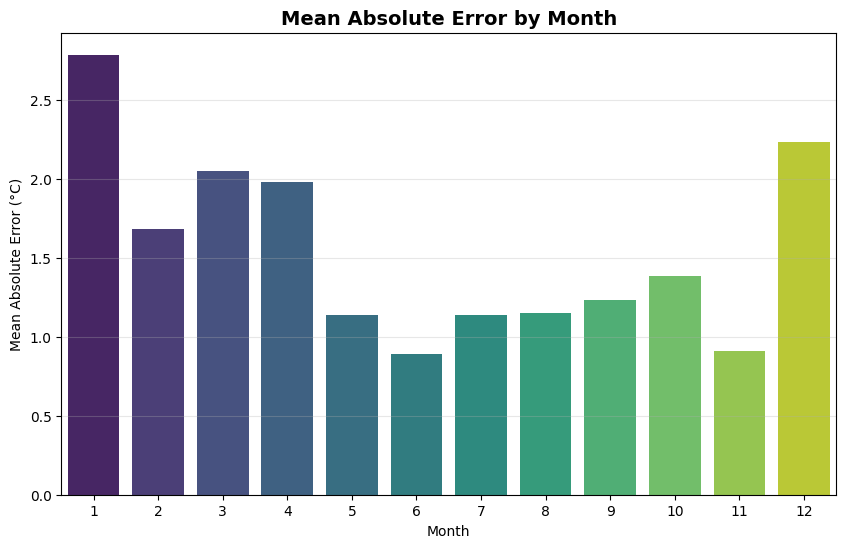


=== ANALYSIS OF ERRORS BY PRECIPITATION ===
Mean Absolute Error by Precipitation Level:
Precipitation
No Rain          1.979536
Light Rain       1.854068
Moderate Rain    1.148250
Heavy Rain       0.966056
Name: Absolute_Error, dtype: float64


/tmp/ipython-input-1571912565.py:86: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  errors_by_precipitation = largest_errors_df.groupby(precipitation_bins)['Absolute_Error'].mean().sort_values(ascending=False)
/tmp/ipython-input-1571912565.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=errors_by_precipitation.index, y=errors_by_precipitation.values, palette='plasma')


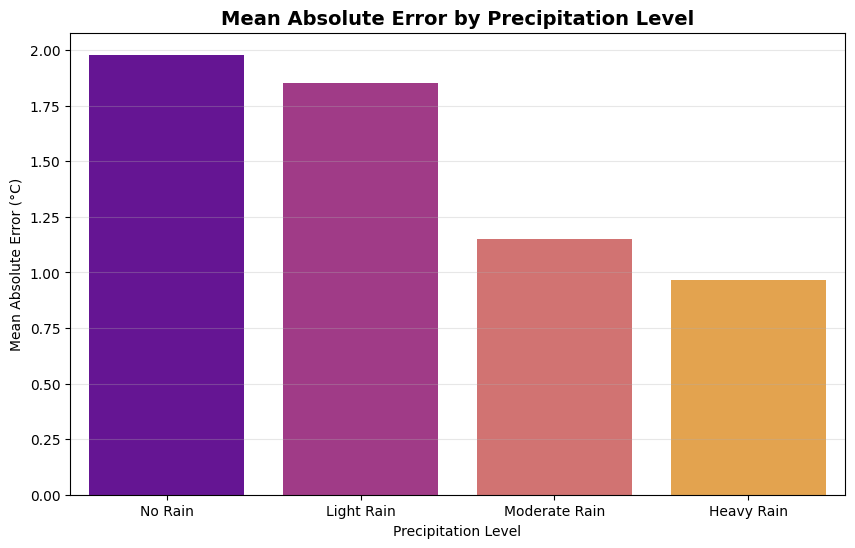


=== EXERCISE 5 COMPLETED ===


In [56]:
# Exercise 5: Error Analysis

print("=== EXERCISE 5: ANALYZING PREDICTION ERRORS ===")

# Re-run the evaluation with the best model from previous exercises (e.g., Exercise 2 or 3)
# Let's use the model trained with the best hidden units from Exercise 2 and the best sequence length from Exercise 1
# You might choose a different model based on your analysis of previous exercises.

best_sequence_length_ex5 = 3 # Based on Exercise 1 results
best_hidden_units_ex5 = 128 # Based on Exercise 2 results

print(f"Using Sequence Length: {best_sequence_length_ex5} and Hidden Units: {best_hidden_units_ex5}")

# Prepare data with the selected parameters
(X_train_ex5, y_train_ex5), (X_val_ex5, y_val_ex5), (X_test_ex5, y_test_ex5) = prepare_data_for_simple_rnn(
    train_data, val_data, test_data,
    feature_columns, 'Temperature',
    feature_scaler, target_scaler,
    sequence_length=best_sequence_length_ex5
)

# Create and train the model with the selected parameters
model_ex5 = create_simple_rnn_model(
    (X_train_ex5.shape[1], X_train_ex5.shape[2]),
    hidden_units=best_hidden_units_ex5,
    dropout_rate=0.2
)

print("\nStarting training for Error Analysis model...")
history_ex5 = train_simple_rnn_model(
    model_ex5, X_train_ex5, y_train_ex5, X_val_ex5, y_val_ex5,
    epochs=50,
    batch_size=32,
    patience=5
)


# Evaluate the model to get predictions and true values
evaluation_results_ex5 = evaluate_simple_rnn_performance(model_ex5, X_test_ex5, y_test_ex5, target_scaler)

y_true_ex5 = evaluation_results_ex5['y_true']
y_pred_ex5 = evaluation_results_ex5['y_pred']
errors_ex5 = y_true_ex5 - y_pred_ex5

# 1. Analyze large errors
print("\n=== ANALYSIS OF LARGE ERRORS ===")

# Get the original test data to join with errors
test_data_ex5 = test_data.iloc[best_sequence_length_ex5:].copy() # Adjust for sequence length offset
test_data_ex5['Actual_Temperature'] = y_true_ex5
test_data_ex5['Predicted_Temperature'] = y_pred_ex5
test_data_ex5['Error'] = errors_ex5
test_data_ex5['Absolute_Error'] = np.abs(errors_ex5)

# Sort by absolute error to find largest errors
largest_errors_df = test_data_ex5.sort_values(by='Absolute_Error', ascending=False)

print("\nTop 10 largest absolute errors:")
display(largest_errors_df[['Actual_Temperature', 'Predicted_Temperature', 'Error', 'Absolute_Error']].head(10))

# 2. Analyze errors by Month (Seasonality)
print("\n=== ANALYSIS OF ERRORS BY MONTH ===")
errors_by_month = largest_errors_df.groupby('Month')['Absolute_Error'].mean().sort_values(ascending=False)
print("Mean Absolute Error by Month:")
print(errors_by_month)

# Visualize errors by month
plt.figure(figsize=(10, 6))
sns.barplot(x=errors_by_month.index, y=errors_by_month.values, palette='viridis')
plt.title('Mean Absolute Error by Month', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Mean Absolute Error (°C)')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()


# 3. Analyze errors by Precipitation levels
print("\n=== ANALYSIS OF ERRORS BY PRECIPITATION ===")

# Create precipitation bins
precipitation_bins = pd.cut(largest_errors_df['Precipitation'], bins=[-1, 0, 5, 20, largest_errors_df['Precipitation'].max()],
                           labels=['No Rain', 'Light Rain', 'Moderate Rain', 'Heavy Rain'],
                           right=True) # Use right=True for inclusive right edge

errors_by_precipitation = largest_errors_df.groupby(precipitation_bins)['Absolute_Error'].mean().sort_values(ascending=False)

print("Mean Absolute Error by Precipitation Level:")
print(errors_by_precipitation)

# Visualize errors by precipitation
plt.figure(figsize=(10, 6))
sns.barplot(x=errors_by_precipitation.index, y=errors_by_precipitation.values, palette='plasma')
plt.title('Mean Absolute Error by Precipitation Level', fontsize=14, fontweight='bold')
plt.xlabel('Precipitation Level')
plt.ylabel('Mean Absolute Error (°C)')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

print("\n=== EXERCISE 5 COMPLETED ===")